In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1
import os, cv2, glob, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import matplotlib.pyplot as plt

# Configurations
IMG_H, IMG_W = 598, 96
CHANNELS = 3
NUM_CLASSES = 7
LATENT_DIM = 100
BATCH_SIZE = 28
EPOCHS = 500

# Local image/label paths
IMAGE_DIR = '/content/images'
LABEL_DIR = '/content/labels'

# Checkpoint path
CHECKPOINT_DIR = '/content/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
# Cell 2
!mkdir -p /content/images
!mkdir -p /content/labels
!cp /content/drive/MyDrive/GenGAN/1_dataset/images/*.png /content/images/
!cp /content/drive/MyDrive/GenGAN/1_dataset/labels/*.txt /content/labels/

In [4]:
# Cell 3
import re

def clean_stem(name):
    match = re.match(r'^(.*?\(\d+\))', name)
    return match.group(1) if match else name

class_to_paths = {i: [] for i in range(NUM_CLASSES)}
all_image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.png'))

for img_path in all_image_paths:
    stem = os.path.splitext(os.path.basename(img_path))[0]
    cleaned = clean_stem(stem)
    lbl_file = os.path.join(LABEL_DIR, cleaned + '.txt')

    if not os.path.exists(lbl_file): continue
    with open(lbl_file, 'r') as f:
        label_id = int(f.readline().strip().split()[0])
    if label_id in class_to_paths:
        class_to_paths[label_id].append(img_path)

In [5]:
# Cell 4
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_H, IMG_W], antialias=True)
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

def load_pair(img_path, label):
    return load_image(img_path), label

datasets = []
for class_id, paths in class_to_paths.items():
    labels = tf.one_hot([class_id]*len(paths), NUM_CLASSES)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    datasets.append(ds)

balanced_ds = tf.data.Dataset.sample_from_datasets(datasets, weights=[1/NUM_CLASSES]*NUM_CLASSES)
dataset = (balanced_ds.shuffle(1000)
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

In [6]:
# Cell 5
noise_input = Input((LATENT_DIM,))
label_input = Input((NUM_CLASSES,))
x = layers.Concatenate()([noise_input, label_input])

x = layers.Dense(75*12*128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((75, 12, 128))(x)

for f in [64, 32]:
    x = layers.Conv2DTranspose(f, 4, 2, 'same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(CHANNELS, 4, 2, activation='tanh', padding='same')(x)
x = layers.Cropping2D(((1,1),(0,0)))(x)

generator = Model([noise_input, label_input], x)
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 107)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 115200)    │ 12,326,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 115200)    │    460,800 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 115200)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 75, 12,    │          0 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 150, 24,   │    131,072 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 24,   │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 150, 24,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 300, 48,   │     32,768 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 48,   │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 300, 48,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 600, 96,   │      1,539 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 598, 96,   │          0 │ conv2d_transpose… │
│ (Cropping2D)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,952,963 (49.41 MB)

 Trainable params: 12,722,371 (48.53 MB)

 Non-trainable params: 230,592 (900.75 KB)

In [7]:
# Cell 6
img_input = Input((IMG_H, IMG_W, CHANNELS))
label_input = Input((NUM_CLASSES,))
y = layers.Dense(IMG_H * IMG_W)(label_input)
y = layers.Reshape((IMG_H, IMG_W, 1))(y)

x = layers.Concatenate()([img_input, y])

for f in [32, 64]:
    x = layers.Conv2D(f, 5, 2, 'same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1)(x)

discriminator = Model([img_input, label_input], x)
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 57408)     │    459,264 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 598, 96,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 598, 96,   │          0 │ dense_1[0][0]     │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 598, 96,   │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 4)                │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 299, 48,   │      3,232 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 299, 48,   │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 299, 48,   │          0 │ leaky_re_lu_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 24,   │     51,264 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 150, 24,   │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 150, 24,   │          0 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,825 (1.96 MB)

 Trainable params: 513,825 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cell 7
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

g_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)

discriminator.compile(optimizer=d_opt, loss=loss_fn)

In [9]:
# Cell 8
@tf.function
def train_step(real_img, label):
    noise = tf.random.normal((BATCH_SIZE, LATENT_DIM))
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_img = generator([noise, label], training=True)
        real_out = discriminator([real_img, label], training=True)
        fake_out = discriminator([fake_img, label], training=True)

        d_loss = loss_fn(tf.ones_like(real_out), real_out) + loss_fn(tf.zeros_like(fake_out), fake_out)
        g_loss = loss_fn(tf.ones_like(fake_out), fake_out)

    d_grad = d_tape.gradient(d_loss, discriminator.trainable_weights)
    g_grad = g_tape.gradient(g_loss, generator.trainable_weights)

    d_opt.apply_gradients(zip(d_grad, discriminator.trainable_weights))
    g_opt.apply_gradients(zip(g_grad, generator.trainable_weights))

    return g_loss, d_loss

Epoch 001: 0it [00:00, ?it/s]

Epoch 001 | Gen Loss: 0.6565 | Disc Loss: 1.1652


Epoch 002: 0it [00:00, ?it/s]

Epoch 002 | Gen Loss: 0.6287 | Disc Loss: 1.0461


Epoch 003: 0it [00:00, ?it/s]

Epoch 003 | Gen Loss: 0.7596 | Disc Loss: 0.8986


Epoch 004: 0it [00:00, ?it/s]

Epoch 004 | Gen Loss: 0.9141 | Disc Loss: 0.7907


Epoch 005: 0it [00:00, ?it/s]

Epoch 005 | Gen Loss: 1.1821 | Disc Loss: 0.6980


Epoch 006: 0it [00:00, ?it/s]

Epoch 006 | Gen Loss: 1.5146 | Disc Loss: 0.5541


Epoch 007: 0it [00:00, ?it/s]

Epoch 007 | Gen Loss: 1.6749 | Disc Loss: 0.5548


Epoch 008: 0it [00:00, ?it/s]

Epoch 008 | Gen Loss: 1.9892 | Disc Loss: 0.4955


Epoch 009: 0it [00:00, ?it/s]

Epoch 009 | Gen Loss: 0.6988 | Disc Loss: 1.5560


Epoch 010: 0it [00:00, ?it/s]

Checkpoint saved at epoch 10
Epoch 010 | Gen Loss: 0.6573 | Disc Loss: 1.4975


Epoch 011: 0it [00:00, ?it/s]

Epoch 011 | Gen Loss: 0.7009 | Disc Loss: 1.4575


Epoch 012: 0it [00:00, ?it/s]

Epoch 012 | Gen Loss: 0.7033 | Disc Loss: 1.4481


Epoch 013: 0it [00:00, ?it/s]

Epoch 013 | Gen Loss: 0.7053 | Disc Loss: 1.4380


Epoch 014: 0it [00:00, ?it/s]

Epoch 014 | Gen Loss: 0.7151 | Disc Loss: 1.4304


Epoch 015: 0it [00:00, ?it/s]

Epoch 015 | Gen Loss: 0.7135 | Disc Loss: 1.4230


Epoch 016: 0it [00:00, ?it/s]

Epoch 016 | Gen Loss: 0.7129 | Disc Loss: 1.4194


Epoch 017: 0it [00:00, ?it/s]

Epoch 017 | Gen Loss: 0.7155 | Disc Loss: 1.4203


Epoch 018: 0it [00:00, ?it/s]

Epoch 018 | Gen Loss: 0.7078 | Disc Loss: 1.4201


Epoch 019: 0it [00:00, ?it/s]

Epoch 019 | Gen Loss: 0.7087 | Disc Loss: 1.4174


Epoch 020: 0it [00:00, ?it/s]

Checkpoint saved at epoch 20
Epoch 020 | Gen Loss: 0.7177 | Disc Loss: 1.4133


Epoch 021: 0it [00:00, ?it/s]

Epoch 021 | Gen Loss: 0.7140 | Disc Loss: 1.4069


Epoch 022: 0it [00:00, ?it/s]

Epoch 022 | Gen Loss: 0.7203 | Disc Loss: 1.4029


Epoch 023: 0it [00:00, ?it/s]

Epoch 023 | Gen Loss: 0.7177 | Disc Loss: 1.4012


Epoch 024: 0it [00:00, ?it/s]

Epoch 024 | Gen Loss: 0.7226 | Disc Loss: 1.3978


Epoch 025: 0it [00:00, ?it/s]

Epoch 025 | Gen Loss: 0.7197 | Disc Loss: 1.3947


Epoch 026: 0it [00:00, ?it/s]

Epoch 026 | Gen Loss: 0.7313 | Disc Loss: 1.3954


Epoch 027: 0it [00:00, ?it/s]

Epoch 027 | Gen Loss: 0.7247 | Disc Loss: 1.3963


Epoch 028: 0it [00:00, ?it/s]

Epoch 028 | Gen Loss: 0.7307 | Disc Loss: 1.3997


Epoch 029: 0it [00:00, ?it/s]

Epoch 029 | Gen Loss: 0.7283 | Disc Loss: 1.3991


Epoch 030: 0it [00:00, ?it/s]

Checkpoint saved at epoch 30
Epoch 030 | Gen Loss: 0.7232 | Disc Loss: 1.3958


Epoch 031: 0it [00:00, ?it/s]

Epoch 031 | Gen Loss: 0.7197 | Disc Loss: 1.3955


Epoch 032: 0it [00:00, ?it/s]

Epoch 032 | Gen Loss: 0.7139 | Disc Loss: 1.3939


Epoch 033: 0it [00:00, ?it/s]

Epoch 033 | Gen Loss: 0.7078 | Disc Loss: 1.3914


Epoch 034: 0it [00:00, ?it/s]

Epoch 034 | Gen Loss: 0.7060 | Disc Loss: 1.3898


Epoch 035: 0it [00:00, ?it/s]

Epoch 035 | Gen Loss: 0.7007 | Disc Loss: 1.3883


Epoch 036: 0it [00:00, ?it/s]

Epoch 036 | Gen Loss: 0.6952 | Disc Loss: 1.3893


Epoch 037: 0it [00:00, ?it/s]

Epoch 037 | Gen Loss: 0.6868 | Disc Loss: 1.3906


Epoch 038: 0it [00:00, ?it/s]

Epoch 038 | Gen Loss: 0.6830 | Disc Loss: 1.3893


Epoch 039: 0it [00:00, ?it/s]

Epoch 039 | Gen Loss: 0.6827 | Disc Loss: 1.3899


Epoch 040: 0it [00:00, ?it/s]

Checkpoint saved at epoch 40
Epoch 040 | Gen Loss: 0.6808 | Disc Loss: 1.3893


Epoch 041: 0it [00:00, ?it/s]

Epoch 041 | Gen Loss: 0.6817 | Disc Loss: 1.3894


Epoch 042: 0it [00:00, ?it/s]

Epoch 042 | Gen Loss: 0.6878 | Disc Loss: 1.3898


Epoch 043: 0it [00:00, ?it/s]

Epoch 043 | Gen Loss: 0.6903 | Disc Loss: 1.3890


Epoch 044: 0it [00:00, ?it/s]

Epoch 044 | Gen Loss: 0.6892 | Disc Loss: 1.3886


Epoch 045: 0it [00:00, ?it/s]

Epoch 045 | Gen Loss: 0.6955 | Disc Loss: 1.3894


Epoch 046: 0it [00:00, ?it/s]

Epoch 046 | Gen Loss: 0.6903 | Disc Loss: 1.3900


Epoch 047: 0it [00:00, ?it/s]

Epoch 047 | Gen Loss: 0.6921 | Disc Loss: 1.3899


Epoch 048: 0it [00:00, ?it/s]

Epoch 048 | Gen Loss: 0.6911 | Disc Loss: 1.3899


Epoch 049: 0it [00:00, ?it/s]

Epoch 049 | Gen Loss: 0.6906 | Disc Loss: 1.3930


Epoch 050: 0it [00:00, ?it/s]

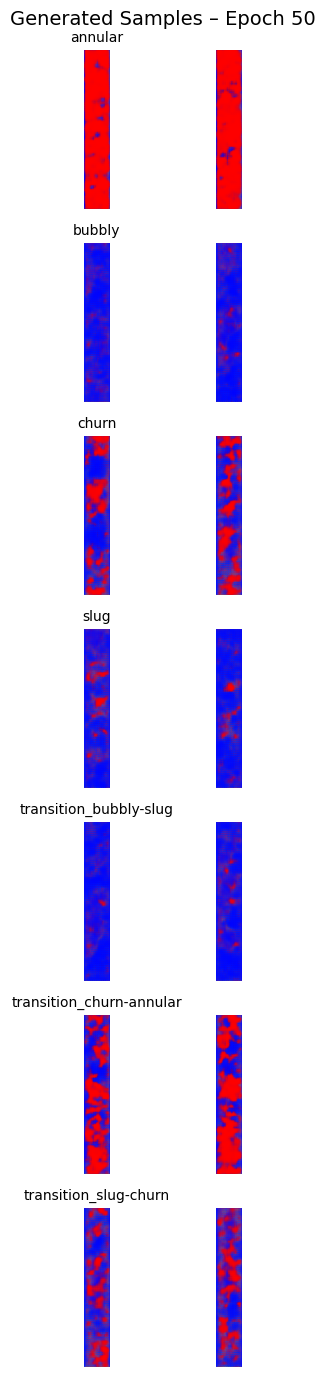

Checkpoint saved at epoch 50
Epoch 050 | Gen Loss: 0.6891 | Disc Loss: 1.3916


Epoch 051: 0it [00:00, ?it/s]

Epoch 051 | Gen Loss: 0.6909 | Disc Loss: 1.3919


Epoch 052: 0it [00:00, ?it/s]

Epoch 052 | Gen Loss: 0.6894 | Disc Loss: 1.3919


Epoch 053: 0it [00:00, ?it/s]

Epoch 053 | Gen Loss: 0.6902 | Disc Loss: 1.3904


Epoch 054: 0it [00:00, ?it/s]

Epoch 054 | Gen Loss: 0.6920 | Disc Loss: 1.3910


Epoch 055: 0it [00:00, ?it/s]

Epoch 055 | Gen Loss: 0.6915 | Disc Loss: 1.3909


Epoch 056: 0it [00:00, ?it/s]

Epoch 056 | Gen Loss: 0.6890 | Disc Loss: 1.3900


Epoch 057: 0it [00:00, ?it/s]

Epoch 057 | Gen Loss: 0.6912 | Disc Loss: 1.3909


Epoch 058: 0it [00:00, ?it/s]

Epoch 058 | Gen Loss: 0.6897 | Disc Loss: 1.3896


Epoch 059: 0it [00:00, ?it/s]

Epoch 059 | Gen Loss: 0.6932 | Disc Loss: 1.3922


Epoch 060: 0it [00:00, ?it/s]

Checkpoint saved at epoch 60
Epoch 060 | Gen Loss: 0.6891 | Disc Loss: 1.3903


Epoch 061: 0it [00:00, ?it/s]

Epoch 061 | Gen Loss: 0.6942 | Disc Loss: 1.3906


Epoch 062: 0it [00:00, ?it/s]

Epoch 062 | Gen Loss: 0.6903 | Disc Loss: 1.3899


Epoch 063: 0it [00:00, ?it/s]

Epoch 063 | Gen Loss: 0.6943 | Disc Loss: 1.3907


Epoch 064: 0it [00:00, ?it/s]

Epoch 064 | Gen Loss: 0.6929 | Disc Loss: 1.3894


Epoch 065: 0it [00:00, ?it/s]

Epoch 065 | Gen Loss: 0.6933 | Disc Loss: 1.3895


Epoch 066: 0it [00:00, ?it/s]

Epoch 066 | Gen Loss: 0.6967 | Disc Loss: 1.3886


Epoch 067: 0it [00:00, ?it/s]

Epoch 067 | Gen Loss: 0.6900 | Disc Loss: 1.3906


Epoch 068: 0it [00:00, ?it/s]

Epoch 068 | Gen Loss: 0.6936 | Disc Loss: 1.3904


Epoch 069: 0it [00:00, ?it/s]

Epoch 069 | Gen Loss: 0.6956 | Disc Loss: 1.3896


Epoch 070: 0it [00:00, ?it/s]

Checkpoint saved at epoch 70
Epoch 070 | Gen Loss: 0.6905 | Disc Loss: 1.3902


Epoch 071: 0it [00:00, ?it/s]

Epoch 071 | Gen Loss: 0.6942 | Disc Loss: 1.3891


Epoch 072: 0it [00:00, ?it/s]

Epoch 072 | Gen Loss: 0.6929 | Disc Loss: 1.3898


Epoch 073: 0it [00:00, ?it/s]

Epoch 073 | Gen Loss: 0.6930 | Disc Loss: 1.3895


Epoch 074: 0it [00:00, ?it/s]

Epoch 074 | Gen Loss: 0.6922 | Disc Loss: 1.3885


Epoch 075: 0it [00:00, ?it/s]

Epoch 075 | Gen Loss: 0.6946 | Disc Loss: 1.3903


Epoch 076: 0it [00:00, ?it/s]

Epoch 076 | Gen Loss: 0.6935 | Disc Loss: 1.3892


Epoch 077: 0it [00:00, ?it/s]

Epoch 077 | Gen Loss: 0.6921 | Disc Loss: 1.3905


Epoch 078: 0it [00:00, ?it/s]

Epoch 078 | Gen Loss: 0.6922 | Disc Loss: 1.3896


Epoch 079: 0it [00:00, ?it/s]

Epoch 079 | Gen Loss: 0.6929 | Disc Loss: 1.3897


Epoch 080: 0it [00:00, ?it/s]

Checkpoint saved at epoch 80
Epoch 080 | Gen Loss: 0.6932 | Disc Loss: 1.3894


Epoch 081: 0it [00:00, ?it/s]

Epoch 081 | Gen Loss: 0.6938 | Disc Loss: 1.3893


Epoch 082: 0it [00:00, ?it/s]

Epoch 082 | Gen Loss: 0.6927 | Disc Loss: 1.3895


Epoch 083: 0it [00:00, ?it/s]

Epoch 083 | Gen Loss: 0.6947 | Disc Loss: 1.3899


Epoch 084: 0it [00:00, ?it/s]

Epoch 084 | Gen Loss: 0.6915 | Disc Loss: 1.3883


Epoch 085: 0it [00:00, ?it/s]

Epoch 085 | Gen Loss: 0.6957 | Disc Loss: 1.3906


Epoch 086: 0it [00:00, ?it/s]

Epoch 086 | Gen Loss: 0.6940 | Disc Loss: 1.3887


Epoch 087: 0it [00:00, ?it/s]

Epoch 087 | Gen Loss: 0.6916 | Disc Loss: 1.3892


Epoch 088: 0it [00:00, ?it/s]

Epoch 088 | Gen Loss: 0.6940 | Disc Loss: 1.3887


Epoch 089: 0it [00:00, ?it/s]

Epoch 089 | Gen Loss: 0.6934 | Disc Loss: 1.3894


Epoch 090: 0it [00:00, ?it/s]

Checkpoint saved at epoch 90
Epoch 090 | Gen Loss: 0.6940 | Disc Loss: 1.3896


Epoch 091: 0it [00:00, ?it/s]

Epoch 091 | Gen Loss: 0.6927 | Disc Loss: 1.3895


Epoch 092: 0it [00:00, ?it/s]

Epoch 092 | Gen Loss: 0.6954 | Disc Loss: 1.3900


Epoch 093: 0it [00:00, ?it/s]

Epoch 093 | Gen Loss: 0.6934 | Disc Loss: 1.3886


Epoch 094: 0it [00:00, ?it/s]

Epoch 094 | Gen Loss: 0.6926 | Disc Loss: 1.3883


Epoch 095: 0it [00:00, ?it/s]

Epoch 095 | Gen Loss: 0.6927 | Disc Loss: 1.3883


Epoch 096: 0it [00:00, ?it/s]

Epoch 096 | Gen Loss: 0.6941 | Disc Loss: 1.3897


Epoch 097: 0it [00:00, ?it/s]

Epoch 097 | Gen Loss: 0.6912 | Disc Loss: 1.3885


Epoch 098: 0it [00:00, ?it/s]

Epoch 098 | Gen Loss: 0.6917 | Disc Loss: 1.3890


Epoch 099: 0it [00:00, ?it/s]

Epoch 099 | Gen Loss: 0.6968 | Disc Loss: 1.3887


Epoch 100: 0it [00:00, ?it/s]

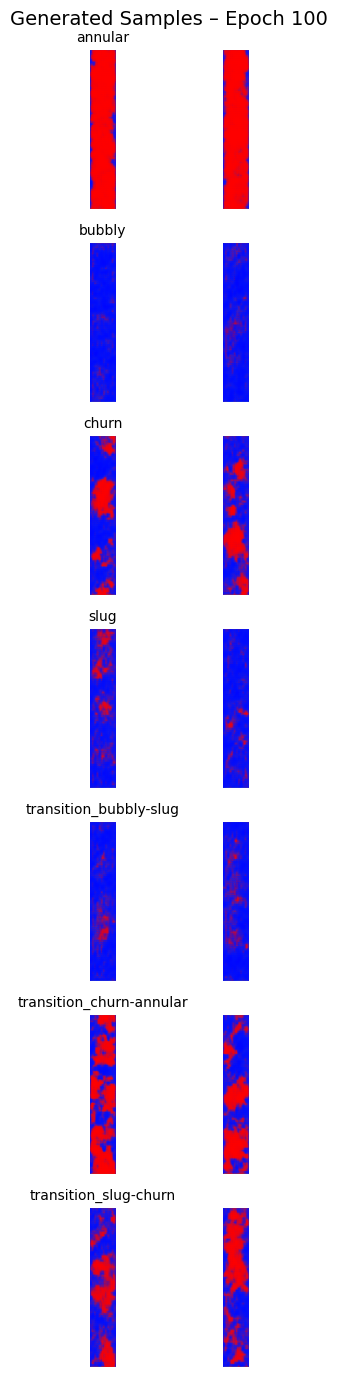

Checkpoint saved at epoch 100
Epoch 100 | Gen Loss: 0.6936 | Disc Loss: 1.3891


Epoch 101: 0it [00:00, ?it/s]

Epoch 101 | Gen Loss: 0.6910 | Disc Loss: 1.3871


Epoch 102: 0it [00:00, ?it/s]

Epoch 102 | Gen Loss: 0.6963 | Disc Loss: 1.3882


Epoch 103: 0it [00:00, ?it/s]

Epoch 103 | Gen Loss: 0.6928 | Disc Loss: 1.3887


Epoch 104: 0it [00:00, ?it/s]

Epoch 104 | Gen Loss: 0.6929 | Disc Loss: 1.3890


Epoch 105: 0it [00:00, ?it/s]

Epoch 105 | Gen Loss: 0.6914 | Disc Loss: 1.3901


Epoch 106: 0it [00:00, ?it/s]

Epoch 106 | Gen Loss: 0.6928 | Disc Loss: 1.3878


Epoch 107: 0it [00:00, ?it/s]

Epoch 107 | Gen Loss: 0.6924 | Disc Loss: 1.3886


Epoch 108: 0it [00:00, ?it/s]

Epoch 108 | Gen Loss: 0.6930 | Disc Loss: 1.3887


Epoch 109: 0it [00:00, ?it/s]

Epoch 109 | Gen Loss: 0.6946 | Disc Loss: 1.3876


Epoch 110: 0it [00:00, ?it/s]

Checkpoint saved at epoch 110
Epoch 110 | Gen Loss: 0.6931 | Disc Loss: 1.3889


Epoch 111: 0it [00:00, ?it/s]

Epoch 111 | Gen Loss: 0.6947 | Disc Loss: 1.3882


Epoch 112: 0it [00:00, ?it/s]

Epoch 112 | Gen Loss: 0.6924 | Disc Loss: 1.3889


Epoch 113: 0it [00:00, ?it/s]

Epoch 113 | Gen Loss: 0.6888 | Disc Loss: 1.3888


Epoch 114: 0it [00:00, ?it/s]

Epoch 114 | Gen Loss: 0.6948 | Disc Loss: 1.3891


Epoch 115: 0it [00:00, ?it/s]

Epoch 115 | Gen Loss: 0.6942 | Disc Loss: 1.3880


Epoch 116: 0it [00:00, ?it/s]

Epoch 116 | Gen Loss: 0.6926 | Disc Loss: 1.3881


Epoch 117: 0it [00:00, ?it/s]

Epoch 117 | Gen Loss: 0.6935 | Disc Loss: 1.3889


Epoch 118: 0it [00:00, ?it/s]

Epoch 118 | Gen Loss: 0.6913 | Disc Loss: 1.3884


Epoch 119: 0it [00:00, ?it/s]

Epoch 119 | Gen Loss: 0.6936 | Disc Loss: 1.3888


Epoch 120: 0it [00:00, ?it/s]

Checkpoint saved at epoch 120
Epoch 120 | Gen Loss: 0.6933 | Disc Loss: 1.3888


Epoch 121: 0it [00:00, ?it/s]

Epoch 121 | Gen Loss: 0.6930 | Disc Loss: 1.3891


Epoch 122: 0it [00:00, ?it/s]

Epoch 122 | Gen Loss: 0.6929 | Disc Loss: 1.3883


Epoch 123: 0it [00:00, ?it/s]

Epoch 123 | Gen Loss: 0.6927 | Disc Loss: 1.3890


Epoch 124: 0it [00:00, ?it/s]

Epoch 124 | Gen Loss: 0.6910 | Disc Loss: 1.3889


Epoch 125: 0it [00:00, ?it/s]

Epoch 125 | Gen Loss: 0.6951 | Disc Loss: 1.3889


Epoch 126: 0it [00:00, ?it/s]

Epoch 126 | Gen Loss: 0.6962 | Disc Loss: 1.3883


Epoch 127: 0it [00:00, ?it/s]

Epoch 127 | Gen Loss: 0.6924 | Disc Loss: 1.3889


Epoch 128: 0it [00:00, ?it/s]

Epoch 128 | Gen Loss: 0.6908 | Disc Loss: 1.3881


Epoch 129: 0it [00:00, ?it/s]

Epoch 129 | Gen Loss: 0.6938 | Disc Loss: 1.3890


Epoch 130: 0it [00:00, ?it/s]

Checkpoint saved at epoch 130
Epoch 130 | Gen Loss: 0.6932 | Disc Loss: 1.3883


Epoch 131: 0it [00:00, ?it/s]

Epoch 131 | Gen Loss: 0.6940 | Disc Loss: 1.3889


Epoch 132: 0it [00:00, ?it/s]

Epoch 132 | Gen Loss: 0.6910 | Disc Loss: 1.3882


Epoch 133: 0it [00:00, ?it/s]

Epoch 133 | Gen Loss: 0.6941 | Disc Loss: 1.3879


Epoch 134: 0it [00:00, ?it/s]

Epoch 134 | Gen Loss: 0.6940 | Disc Loss: 1.3879


Epoch 135: 0it [00:00, ?it/s]

Epoch 135 | Gen Loss: 0.6925 | Disc Loss: 1.3898


Epoch 136: 0it [00:00, ?it/s]

Epoch 136 | Gen Loss: 0.6975 | Disc Loss: 1.3889


Epoch 137: 0it [00:00, ?it/s]

Epoch 137 | Gen Loss: 0.6916 | Disc Loss: 1.3891


Epoch 138: 0it [00:00, ?it/s]

Epoch 138 | Gen Loss: 0.6925 | Disc Loss: 1.3884


Epoch 139: 0it [00:00, ?it/s]

Epoch 139 | Gen Loss: 0.6926 | Disc Loss: 1.3897


Epoch 140: 0it [00:00, ?it/s]

Checkpoint saved at epoch 140
Epoch 140 | Gen Loss: 0.6943 | Disc Loss: 1.3880


Epoch 141: 0it [00:00, ?it/s]

Epoch 141 | Gen Loss: 0.6926 | Disc Loss: 1.3884


Epoch 142: 0it [00:00, ?it/s]

Epoch 142 | Gen Loss: 0.6933 | Disc Loss: 1.3886


Epoch 143: 0it [00:00, ?it/s]

Epoch 143 | Gen Loss: 0.6950 | Disc Loss: 1.3879


Epoch 144: 0it [00:00, ?it/s]

Epoch 144 | Gen Loss: 0.6927 | Disc Loss: 1.3887


Epoch 145: 0it [00:00, ?it/s]

Epoch 145 | Gen Loss: 0.6929 | Disc Loss: 1.3886


Epoch 146: 0it [00:00, ?it/s]

Epoch 146 | Gen Loss: 0.6914 | Disc Loss: 1.3878


Epoch 147: 0it [00:00, ?it/s]

Epoch 147 | Gen Loss: 0.6949 | Disc Loss: 1.3884


Epoch 148: 0it [00:00, ?it/s]

Epoch 148 | Gen Loss: 0.6913 | Disc Loss: 1.3876


Epoch 149: 0it [00:00, ?it/s]

Epoch 149 | Gen Loss: 0.6947 | Disc Loss: 1.3884


Epoch 150: 0it [00:00, ?it/s]

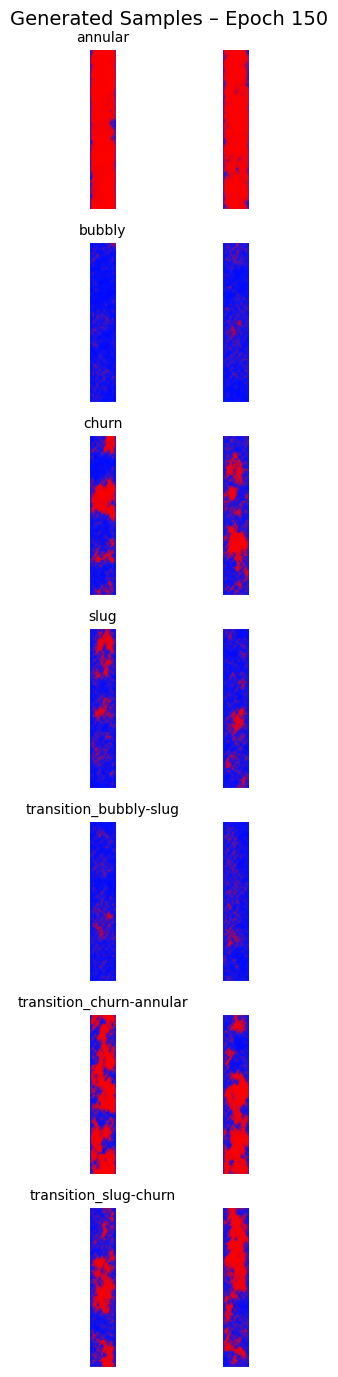

Checkpoint saved at epoch 150
Epoch 150 | Gen Loss: 0.6911 | Disc Loss: 1.3887


Epoch 151: 0it [00:00, ?it/s]

Epoch 151 | Gen Loss: 0.6937 | Disc Loss: 1.3885


Epoch 152: 0it [00:00, ?it/s]

Epoch 152 | Gen Loss: 0.6942 | Disc Loss: 1.3885


Epoch 153: 0it [00:00, ?it/s]

Epoch 153 | Gen Loss: 0.6917 | Disc Loss: 1.3879


Epoch 154: 0it [00:00, ?it/s]

Epoch 154 | Gen Loss: 0.6917 | Disc Loss: 1.3883


Epoch 155: 0it [00:00, ?it/s]

Epoch 155 | Gen Loss: 0.6958 | Disc Loss: 1.3883


Epoch 156: 0it [00:00, ?it/s]

Epoch 156 | Gen Loss: 0.6935 | Disc Loss: 1.3883


Epoch 157: 0it [00:00, ?it/s]

Epoch 157 | Gen Loss: 0.6912 | Disc Loss: 1.3886


Epoch 158: 0it [00:00, ?it/s]

Epoch 158 | Gen Loss: 0.6927 | Disc Loss: 1.3896


Epoch 159: 0it [00:00, ?it/s]

Epoch 159 | Gen Loss: 0.6924 | Disc Loss: 1.3890


Epoch 160: 0it [00:00, ?it/s]

Checkpoint saved at epoch 160
Epoch 160 | Gen Loss: 0.6924 | Disc Loss: 1.3893


Epoch 161: 0it [00:00, ?it/s]

Epoch 161 | Gen Loss: 0.6936 | Disc Loss: 1.3884


Epoch 162: 0it [00:00, ?it/s]

Epoch 162 | Gen Loss: 0.6935 | Disc Loss: 1.3882


Epoch 163: 0it [00:00, ?it/s]

Epoch 163 | Gen Loss: 0.6938 | Disc Loss: 1.3880


Epoch 164: 0it [00:00, ?it/s]

Epoch 164 | Gen Loss: 0.6951 | Disc Loss: 1.3885


Epoch 165: 0it [00:00, ?it/s]

Epoch 165 | Gen Loss: 0.6910 | Disc Loss: 1.3894


Epoch 166: 0it [00:00, ?it/s]

Epoch 166 | Gen Loss: 0.6929 | Disc Loss: 1.3873


Epoch 167: 0it [00:00, ?it/s]

Epoch 167 | Gen Loss: 0.6957 | Disc Loss: 1.3871


Epoch 168: 0it [00:00, ?it/s]

Epoch 168 | Gen Loss: 0.6922 | Disc Loss: 1.3881


Epoch 169: 0it [00:00, ?it/s]

Epoch 169 | Gen Loss: 0.6956 | Disc Loss: 1.3875


Epoch 170: 0it [00:00, ?it/s]

Checkpoint saved at epoch 170
Epoch 170 | Gen Loss: 0.6927 | Disc Loss: 1.3881


Epoch 171: 0it [00:00, ?it/s]

Epoch 171 | Gen Loss: 0.6934 | Disc Loss: 1.3879


Epoch 172: 0it [00:00, ?it/s]

Epoch 172 | Gen Loss: 0.6917 | Disc Loss: 1.3889


Epoch 173: 0it [00:00, ?it/s]

Epoch 173 | Gen Loss: 0.6976 | Disc Loss: 1.3885


Epoch 174: 0it [00:00, ?it/s]

Epoch 174 | Gen Loss: 0.6905 | Disc Loss: 1.3883


Epoch 175: 0it [00:00, ?it/s]

Epoch 175 | Gen Loss: 0.6898 | Disc Loss: 1.3872


Epoch 176: 0it [00:00, ?it/s]

Epoch 176 | Gen Loss: 0.6972 | Disc Loss: 1.3876


Epoch 177: 0it [00:00, ?it/s]

Epoch 177 | Gen Loss: 0.6928 | Disc Loss: 1.3883


Epoch 178: 0it [00:00, ?it/s]

Epoch 178 | Gen Loss: 0.6947 | Disc Loss: 1.3887


Epoch 179: 0it [00:00, ?it/s]

Epoch 179 | Gen Loss: 0.6929 | Disc Loss: 1.3891


Epoch 180: 0it [00:00, ?it/s]

Checkpoint saved at epoch 180
Epoch 180 | Gen Loss: 0.6925 | Disc Loss: 1.3879


Epoch 181: 0it [00:00, ?it/s]

Epoch 181 | Gen Loss: 0.6945 | Disc Loss: 1.3885


Epoch 182: 0it [00:00, ?it/s]

Epoch 182 | Gen Loss: 0.6933 | Disc Loss: 1.3875


Epoch 183: 0it [00:00, ?it/s]

Epoch 183 | Gen Loss: 0.6914 | Disc Loss: 1.3878


Epoch 184: 0it [00:00, ?it/s]

Epoch 184 | Gen Loss: 0.6945 | Disc Loss: 1.3877


Epoch 185: 0it [00:00, ?it/s]

Epoch 185 | Gen Loss: 0.6946 | Disc Loss: 1.3886


Epoch 186: 0it [00:00, ?it/s]

Epoch 186 | Gen Loss: 0.6917 | Disc Loss: 1.3878


Epoch 187: 0it [00:00, ?it/s]

Epoch 187 | Gen Loss: 0.6962 | Disc Loss: 1.3879


Epoch 188: 0it [00:00, ?it/s]

Epoch 188 | Gen Loss: 0.6937 | Disc Loss: 1.3882


Epoch 189: 0it [00:00, ?it/s]

Epoch 189 | Gen Loss: 0.6898 | Disc Loss: 1.3887


Epoch 190: 0it [00:00, ?it/s]

Checkpoint saved at epoch 190
Epoch 190 | Gen Loss: 0.6961 | Disc Loss: 1.3878


Epoch 191: 0it [00:00, ?it/s]

Epoch 191 | Gen Loss: 0.6915 | Disc Loss: 1.3878


Epoch 192: 0it [00:00, ?it/s]

Epoch 192 | Gen Loss: 0.6938 | Disc Loss: 1.3877


Epoch 193: 0it [00:00, ?it/s]

Epoch 193 | Gen Loss: 0.6939 | Disc Loss: 1.3874


Epoch 194: 0it [00:00, ?it/s]

Epoch 194 | Gen Loss: 0.6969 | Disc Loss: 1.3868


Epoch 195: 0it [00:00, ?it/s]

Epoch 195 | Gen Loss: 0.6917 | Disc Loss: 1.3883


Epoch 196: 0it [00:00, ?it/s]

Epoch 196 | Gen Loss: 0.6946 | Disc Loss: 1.3874


Epoch 197: 0it [00:00, ?it/s]

Epoch 197 | Gen Loss: 0.6932 | Disc Loss: 1.3879


Epoch 198: 0it [00:00, ?it/s]

Epoch 198 | Gen Loss: 0.6916 | Disc Loss: 1.3884


Epoch 199: 0it [00:00, ?it/s]

Epoch 199 | Gen Loss: 0.6963 | Disc Loss: 1.3887


Epoch 200: 0it [00:00, ?it/s]

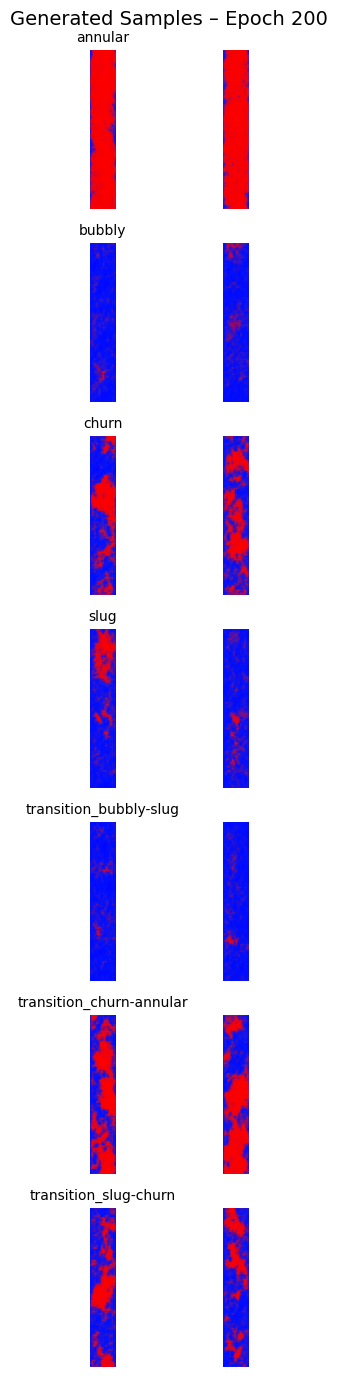

Checkpoint saved at epoch 200
Epoch 200 | Gen Loss: 0.6916 | Disc Loss: 1.3878


Epoch 201: 0it [00:00, ?it/s]

Epoch 201 | Gen Loss: 0.6953 | Disc Loss: 1.3874


Epoch 202: 0it [00:00, ?it/s]

Epoch 202 | Gen Loss: 0.6941 | Disc Loss: 1.3876


Epoch 203: 0it [00:00, ?it/s]

Epoch 203 | Gen Loss: 0.6913 | Disc Loss: 1.3872


Epoch 204: 0it [00:00, ?it/s]

Epoch 204 | Gen Loss: 0.6930 | Disc Loss: 1.3885


Epoch 205: 0it [00:00, ?it/s]

Epoch 205 | Gen Loss: 0.6941 | Disc Loss: 1.3880


Epoch 206: 0it [00:00, ?it/s]

Epoch 206 | Gen Loss: 0.6930 | Disc Loss: 1.3879


Epoch 207: 0it [00:00, ?it/s]

Epoch 207 | Gen Loss: 0.6971 | Disc Loss: 1.3880


Epoch 208: 0it [00:00, ?it/s]

Epoch 208 | Gen Loss: 0.6934 | Disc Loss: 1.3881


Epoch 209: 0it [00:00, ?it/s]

Epoch 209 | Gen Loss: 0.6908 | Disc Loss: 1.3883


Epoch 210: 0it [00:00, ?it/s]

Checkpoint saved at epoch 210
Epoch 210 | Gen Loss: 0.6927 | Disc Loss: 1.3879


Epoch 211: 0it [00:00, ?it/s]

Epoch 211 | Gen Loss: 0.6951 | Disc Loss: 1.3878


Epoch 212: 0it [00:00, ?it/s]

Epoch 212 | Gen Loss: 0.6935 | Disc Loss: 1.3880


Epoch 213: 0it [00:00, ?it/s]

Epoch 213 | Gen Loss: 0.6942 | Disc Loss: 1.3879


Epoch 214: 0it [00:00, ?it/s]

Epoch 214 | Gen Loss: 0.6932 | Disc Loss: 1.3877


Epoch 215: 0it [00:00, ?it/s]

Epoch 215 | Gen Loss: 0.6943 | Disc Loss: 1.3871


Epoch 216: 0it [00:00, ?it/s]

Epoch 216 | Gen Loss: 0.6941 | Disc Loss: 1.3876


Epoch 217: 0it [00:00, ?it/s]

Epoch 217 | Gen Loss: 0.6928 | Disc Loss: 1.3887


Epoch 218: 0it [00:00, ?it/s]

Epoch 218 | Gen Loss: 0.6946 | Disc Loss: 1.3878


Epoch 219: 0it [00:00, ?it/s]

Epoch 219 | Gen Loss: 0.6915 | Disc Loss: 1.3872


Epoch 220: 0it [00:00, ?it/s]

Checkpoint saved at epoch 220
Epoch 220 | Gen Loss: 0.6930 | Disc Loss: 1.3873


Epoch 221: 0it [00:00, ?it/s]

Epoch 221 | Gen Loss: 0.6954 | Disc Loss: 1.3876


Epoch 222: 0it [00:00, ?it/s]

Epoch 222 | Gen Loss: 0.6958 | Disc Loss: 1.3877


Epoch 223: 0it [00:00, ?it/s]

Epoch 223 | Gen Loss: 0.6928 | Disc Loss: 1.3874


Epoch 224: 0it [00:00, ?it/s]

Epoch 224 | Gen Loss: 0.6924 | Disc Loss: 1.3877


Epoch 225: 0it [00:00, ?it/s]

Epoch 225 | Gen Loss: 0.6922 | Disc Loss: 1.3876


Epoch 226: 0it [00:00, ?it/s]

Epoch 226 | Gen Loss: 0.6927 | Disc Loss: 1.3872


Epoch 227: 0it [00:00, ?it/s]

Epoch 227 | Gen Loss: 0.6941 | Disc Loss: 1.3875


Epoch 228: 0it [00:00, ?it/s]

Epoch 228 | Gen Loss: 0.6947 | Disc Loss: 1.3879


Epoch 229: 0it [00:00, ?it/s]

Epoch 229 | Gen Loss: 0.6957 | Disc Loss: 1.3879


Epoch 230: 0it [00:00, ?it/s]

Checkpoint saved at epoch 230
Epoch 230 | Gen Loss: 0.6940 | Disc Loss: 1.3872


Epoch 231: 0it [00:00, ?it/s]

Epoch 231 | Gen Loss: 0.6919 | Disc Loss: 1.3872


Epoch 232: 0it [00:00, ?it/s]

Epoch 232 | Gen Loss: 0.6927 | Disc Loss: 1.3874


Epoch 233: 0it [00:00, ?it/s]

Epoch 233 | Gen Loss: 0.6940 | Disc Loss: 1.3873


Epoch 234: 0it [00:00, ?it/s]

Epoch 234 | Gen Loss: 0.6940 | Disc Loss: 1.3879


Epoch 235: 0it [00:00, ?it/s]

Epoch 235 | Gen Loss: 0.6944 | Disc Loss: 1.3877


Epoch 236: 0it [00:00, ?it/s]

Epoch 236 | Gen Loss: 0.6922 | Disc Loss: 1.3877


Epoch 237: 0it [00:00, ?it/s]

Epoch 237 | Gen Loss: 0.6936 | Disc Loss: 1.3883


Epoch 238: 0it [00:00, ?it/s]

Epoch 238 | Gen Loss: 0.6928 | Disc Loss: 1.3879


Epoch 239: 0it [00:00, ?it/s]

Epoch 239 | Gen Loss: 0.6925 | Disc Loss: 1.3873


Epoch 240: 0it [00:00, ?it/s]

Checkpoint saved at epoch 240
Epoch 240 | Gen Loss: 0.6950 | Disc Loss: 1.3883


Epoch 241: 0it [00:00, ?it/s]

Epoch 241 | Gen Loss: 0.6919 | Disc Loss: 1.3876


Epoch 242: 0it [00:00, ?it/s]

Epoch 242 | Gen Loss: 0.6943 | Disc Loss: 1.3876


Epoch 243: 0it [00:00, ?it/s]

Epoch 243 | Gen Loss: 0.6906 | Disc Loss: 1.3880


Epoch 244: 0it [00:00, ?it/s]

Epoch 244 | Gen Loss: 0.6953 | Disc Loss: 1.3874


Epoch 245: 0it [00:00, ?it/s]

Epoch 245 | Gen Loss: 0.6952 | Disc Loss: 1.3874


Epoch 246: 0it [00:00, ?it/s]

Epoch 246 | Gen Loss: 0.6931 | Disc Loss: 1.3882


Epoch 247: 0it [00:00, ?it/s]

Epoch 247 | Gen Loss: 0.6935 | Disc Loss: 1.3877


Epoch 248: 0it [00:00, ?it/s]

Epoch 248 | Gen Loss: 0.6925 | Disc Loss: 1.3868


Epoch 249: 0it [00:00, ?it/s]

Epoch 249 | Gen Loss: 0.6944 | Disc Loss: 1.3872


Epoch 250: 0it [00:00, ?it/s]

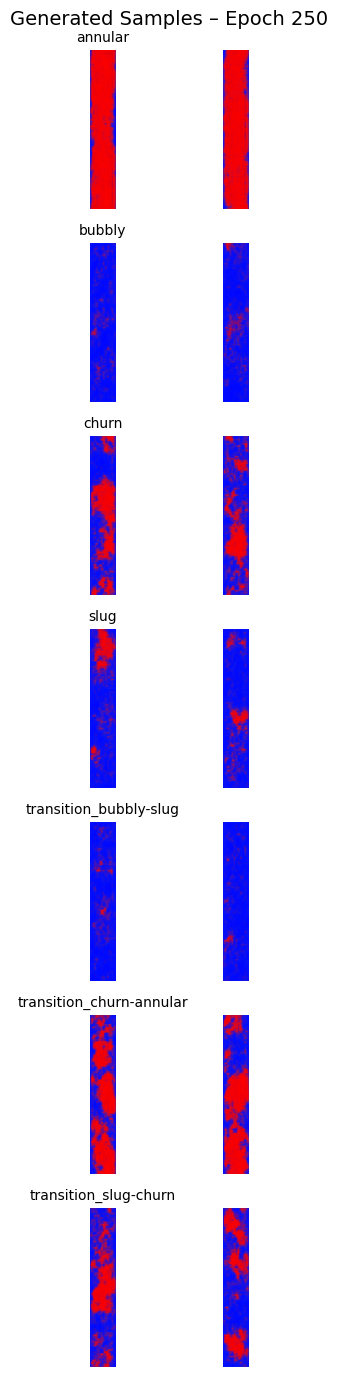

Checkpoint saved at epoch 250
Epoch 250 | Gen Loss: 0.6945 | Disc Loss: 1.3873


Epoch 251: 0it [00:00, ?it/s]

Epoch 251 | Gen Loss: 0.6909 | Disc Loss: 1.3866


Epoch 252: 0it [00:00, ?it/s]

Epoch 252 | Gen Loss: 0.6926 | Disc Loss: 1.3875


Epoch 253: 0it [00:00, ?it/s]

Epoch 253 | Gen Loss: 0.6951 | Disc Loss: 1.3873


Epoch 254: 0it [00:00, ?it/s]

Epoch 254 | Gen Loss: 0.6936 | Disc Loss: 1.3873


Epoch 255: 0it [00:00, ?it/s]

Epoch 255 | Gen Loss: 0.6945 | Disc Loss: 1.3876


Epoch 256: 0it [00:00, ?it/s]

Epoch 256 | Gen Loss: 0.6943 | Disc Loss: 1.3874


Epoch 257: 0it [00:00, ?it/s]

Epoch 257 | Gen Loss: 0.6892 | Disc Loss: 1.3875


Epoch 258: 0it [00:00, ?it/s]

Epoch 258 | Gen Loss: 0.6931 | Disc Loss: 1.3868


Epoch 259: 0it [00:00, ?it/s]

Epoch 259 | Gen Loss: 0.6941 | Disc Loss: 1.3880


Epoch 260: 0it [00:00, ?it/s]

Checkpoint saved at epoch 260
Epoch 260 | Gen Loss: 0.6964 | Disc Loss: 1.3874


Epoch 261: 0it [00:00, ?it/s]

Epoch 261 | Gen Loss: 0.6930 | Disc Loss: 1.3879


Epoch 262: 0it [00:00, ?it/s]

Epoch 262 | Gen Loss: 0.6934 | Disc Loss: 1.3875


Epoch 263: 0it [00:00, ?it/s]

Epoch 263 | Gen Loss: 0.6928 | Disc Loss: 1.3878


Epoch 264: 0it [00:00, ?it/s]

Epoch 264 | Gen Loss: 0.6942 | Disc Loss: 1.3874


Epoch 265: 0it [00:00, ?it/s]

Epoch 265 | Gen Loss: 0.6943 | Disc Loss: 1.3872


Epoch 266: 0it [00:00, ?it/s]

Epoch 266 | Gen Loss: 0.6913 | Disc Loss: 1.3875


Epoch 267: 0it [00:00, ?it/s]

Epoch 267 | Gen Loss: 0.6960 | Disc Loss: 1.3870


Epoch 268: 0it [00:00, ?it/s]

Epoch 268 | Gen Loss: 0.6932 | Disc Loss: 1.3872


Epoch 269: 0it [00:00, ?it/s]

Epoch 269 | Gen Loss: 0.6945 | Disc Loss: 1.3878


Epoch 270: 0it [00:00, ?it/s]

Checkpoint saved at epoch 270
Epoch 270 | Gen Loss: 0.6930 | Disc Loss: 1.3867


Epoch 271: 0it [00:00, ?it/s]

Epoch 271 | Gen Loss: 0.6927 | Disc Loss: 1.3874


Epoch 272: 0it [00:00, ?it/s]

Epoch 272 | Gen Loss: 0.6945 | Disc Loss: 1.3879


Epoch 273: 0it [00:00, ?it/s]

Epoch 273 | Gen Loss: 0.6928 | Disc Loss: 1.3875


Epoch 274: 0it [00:00, ?it/s]

Epoch 274 | Gen Loss: 0.6948 | Disc Loss: 1.3873


Epoch 275: 0it [00:00, ?it/s]

Epoch 275 | Gen Loss: 0.6930 | Disc Loss: 1.3873


Epoch 276: 0it [00:00, ?it/s]

Epoch 276 | Gen Loss: 0.6927 | Disc Loss: 1.3873


Epoch 277: 0it [00:00, ?it/s]

Epoch 277 | Gen Loss: 0.6942 | Disc Loss: 1.3868


Epoch 278: 0it [00:00, ?it/s]

Epoch 278 | Gen Loss: 0.6936 | Disc Loss: 1.3873


Epoch 279: 0it [00:00, ?it/s]

Epoch 279 | Gen Loss: 0.6920 | Disc Loss: 1.3871


Epoch 280: 0it [00:00, ?it/s]

Checkpoint saved at epoch 280
Epoch 280 | Gen Loss: 0.6927 | Disc Loss: 1.3871


Epoch 281: 0it [00:00, ?it/s]

Epoch 281 | Gen Loss: 0.6971 | Disc Loss: 1.3878


Epoch 282: 0it [00:00, ?it/s]

Epoch 282 | Gen Loss: 0.6936 | Disc Loss: 1.3875


Epoch 283: 0it [00:00, ?it/s]

Epoch 283 | Gen Loss: 0.6928 | Disc Loss: 1.3873


Epoch 284: 0it [00:00, ?it/s]

Epoch 284 | Gen Loss: 0.6929 | Disc Loss: 1.3871


Epoch 285: 0it [00:00, ?it/s]

Epoch 285 | Gen Loss: 0.6946 | Disc Loss: 1.3870


Epoch 286: 0it [00:00, ?it/s]

Epoch 286 | Gen Loss: 0.6926 | Disc Loss: 1.3874


Epoch 287: 0it [00:00, ?it/s]

Epoch 287 | Gen Loss: 0.6930 | Disc Loss: 1.3876


Epoch 288: 0it [00:00, ?it/s]

Epoch 288 | Gen Loss: 0.6930 | Disc Loss: 1.3876


Epoch 289: 0it [00:00, ?it/s]

Epoch 289 | Gen Loss: 0.6943 | Disc Loss: 1.3867


Epoch 290: 0it [00:00, ?it/s]

Checkpoint saved at epoch 290
Epoch 290 | Gen Loss: 0.6942 | Disc Loss: 1.3874


Epoch 291: 0it [00:00, ?it/s]

Epoch 291 | Gen Loss: 0.6935 | Disc Loss: 1.3873


Epoch 292: 0it [00:00, ?it/s]

Epoch 292 | Gen Loss: 0.6942 | Disc Loss: 1.3873


Epoch 293: 0it [00:00, ?it/s]

Epoch 293 | Gen Loss: 0.6953 | Disc Loss: 1.3877


Epoch 294: 0it [00:00, ?it/s]

Epoch 294 | Gen Loss: 0.6919 | Disc Loss: 1.3877


Epoch 295: 0it [00:00, ?it/s]

Epoch 295 | Gen Loss: 0.6924 | Disc Loss: 1.3869


Epoch 296: 0it [00:00, ?it/s]

Epoch 296 | Gen Loss: 0.6963 | Disc Loss: 1.3876


Epoch 297: 0it [00:00, ?it/s]

Epoch 297 | Gen Loss: 0.6933 | Disc Loss: 1.3873


Epoch 298: 0it [00:00, ?it/s]

Epoch 298 | Gen Loss: 0.6923 | Disc Loss: 1.3876


Epoch 299: 0it [00:00, ?it/s]

Epoch 299 | Gen Loss: 0.6922 | Disc Loss: 1.3873


Epoch 300: 0it [00:00, ?it/s]

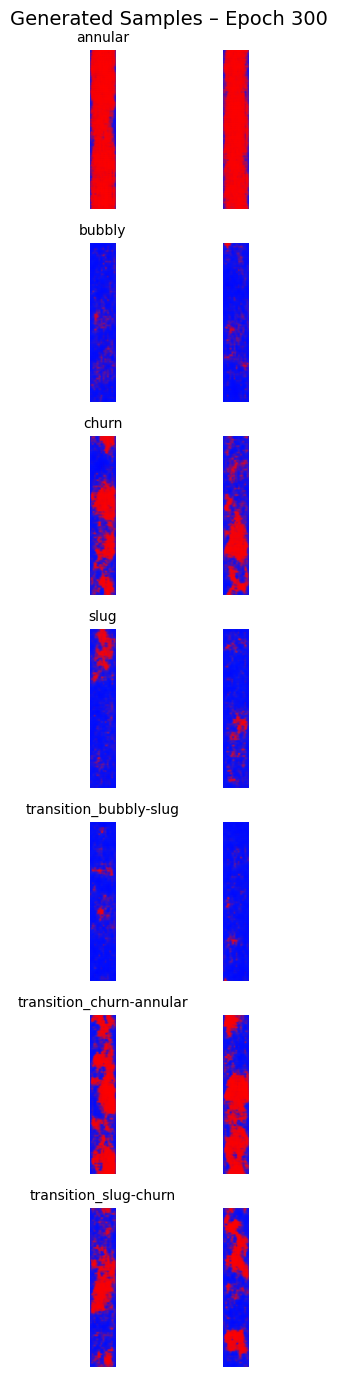

Checkpoint saved at epoch 300
Epoch 300 | Gen Loss: 0.6954 | Disc Loss: 1.3870


Epoch 301: 0it [00:00, ?it/s]

Epoch 301 | Gen Loss: 0.6961 | Disc Loss: 1.3875


Epoch 302: 0it [00:00, ?it/s]

Epoch 302 | Gen Loss: 0.6919 | Disc Loss: 1.3876


Epoch 303: 0it [00:00, ?it/s]

Epoch 303 | Gen Loss: 0.6921 | Disc Loss: 1.3875


Epoch 304: 0it [00:00, ?it/s]

Epoch 304 | Gen Loss: 0.6933 | Disc Loss: 1.3879


Epoch 305: 0it [00:00, ?it/s]

Epoch 305 | Gen Loss: 0.6936 | Disc Loss: 1.3876


Epoch 306: 0it [00:00, ?it/s]

Epoch 306 | Gen Loss: 0.6947 | Disc Loss: 1.3869


Epoch 307: 0it [00:00, ?it/s]

Epoch 307 | Gen Loss: 0.6932 | Disc Loss: 1.3876


Epoch 308: 0it [00:00, ?it/s]

Epoch 308 | Gen Loss: 0.6938 | Disc Loss: 1.3874


Epoch 309: 0it [00:00, ?it/s]

Epoch 309 | Gen Loss: 0.6936 | Disc Loss: 1.3873


Epoch 310: 0it [00:00, ?it/s]

Checkpoint saved at epoch 310
Epoch 310 | Gen Loss: 0.6913 | Disc Loss: 1.3875


Epoch 311: 0it [00:00, ?it/s]

Epoch 311 | Gen Loss: 0.6979 | Disc Loss: 1.3873


Epoch 312: 0it [00:00, ?it/s]

Epoch 312 | Gen Loss: 0.6933 | Disc Loss: 1.3875


Epoch 313: 0it [00:00, ?it/s]

Epoch 313 | Gen Loss: 0.6950 | Disc Loss: 1.3869


Epoch 314: 0it [00:00, ?it/s]

Epoch 314 | Gen Loss: 0.6925 | Disc Loss: 1.3878


Epoch 315: 0it [00:00, ?it/s]

Epoch 315 | Gen Loss: 0.6911 | Disc Loss: 1.3866


Epoch 316: 0it [00:00, ?it/s]

Epoch 316 | Gen Loss: 0.6943 | Disc Loss: 1.3873


Epoch 317: 0it [00:00, ?it/s]

Epoch 317 | Gen Loss: 0.6941 | Disc Loss: 1.3872


Epoch 318: 0it [00:00, ?it/s]

Epoch 318 | Gen Loss: 0.6945 | Disc Loss: 1.3873


Epoch 319: 0it [00:00, ?it/s]

Epoch 319 | Gen Loss: 0.6970 | Disc Loss: 1.3865


Epoch 320: 0it [00:00, ?it/s]

Checkpoint saved at epoch 320
Epoch 320 | Gen Loss: 0.6908 | Disc Loss: 1.3868


Epoch 321: 0it [00:00, ?it/s]

Epoch 321 | Gen Loss: 0.6927 | Disc Loss: 1.3861


Epoch 322: 0it [00:00, ?it/s]

Epoch 322 | Gen Loss: 0.6943 | Disc Loss: 1.3869


Epoch 323: 0it [00:00, ?it/s]

Epoch 323 | Gen Loss: 0.6925 | Disc Loss: 1.3874


Epoch 324: 0it [00:00, ?it/s]

Epoch 324 | Gen Loss: 0.6944 | Disc Loss: 1.3872


Epoch 325: 0it [00:00, ?it/s]

Epoch 325 | Gen Loss: 0.6974 | Disc Loss: 1.3863


Epoch 326: 0it [00:00, ?it/s]

Epoch 326 | Gen Loss: 0.6920 | Disc Loss: 1.3873


Epoch 327: 0it [00:00, ?it/s]

Epoch 327 | Gen Loss: 0.6938 | Disc Loss: 1.3874


Epoch 328: 0it [00:00, ?it/s]

Epoch 328 | Gen Loss: 0.6941 | Disc Loss: 1.3873


Epoch 329: 0it [00:00, ?it/s]

Epoch 329 | Gen Loss: 0.6929 | Disc Loss: 1.3869


Epoch 330: 0it [00:00, ?it/s]

Checkpoint saved at epoch 330
Epoch 330 | Gen Loss: 0.6960 | Disc Loss: 1.3867


Epoch 331: 0it [00:00, ?it/s]

Epoch 331 | Gen Loss: 0.6920 | Disc Loss: 1.3875


Epoch 332: 0it [00:00, ?it/s]

Epoch 332 | Gen Loss: 0.6932 | Disc Loss: 1.3870


Epoch 333: 0it [00:00, ?it/s]

Epoch 333 | Gen Loss: 0.6938 | Disc Loss: 1.3872


Epoch 334: 0it [00:00, ?it/s]

Epoch 334 | Gen Loss: 0.6936 | Disc Loss: 1.3874


Epoch 335: 0it [00:00, ?it/s]

Epoch 335 | Gen Loss: 0.6921 | Disc Loss: 1.3870


Epoch 336: 0it [00:00, ?it/s]

Epoch 336 | Gen Loss: 0.6968 | Disc Loss: 1.3871


Epoch 337: 0it [00:00, ?it/s]

Epoch 337 | Gen Loss: 0.6922 | Disc Loss: 1.3872


Epoch 338: 0it [00:00, ?it/s]

Epoch 338 | Gen Loss: 0.6951 | Disc Loss: 1.3867


Epoch 339: 0it [00:00, ?it/s]

Epoch 339 | Gen Loss: 0.6936 | Disc Loss: 1.3878


Epoch 340: 0it [00:00, ?it/s]

Checkpoint saved at epoch 340
Epoch 340 | Gen Loss: 0.6923 | Disc Loss: 1.3876


Epoch 341: 0it [00:00, ?it/s]

Epoch 341 | Gen Loss: 0.6949 | Disc Loss: 1.3882


Epoch 342: 0it [00:00, ?it/s]

Epoch 342 | Gen Loss: 0.6908 | Disc Loss: 1.3867


Epoch 343: 0it [00:00, ?it/s]

Epoch 343 | Gen Loss: 0.6936 | Disc Loss: 1.3871


Epoch 344: 0it [00:00, ?it/s]

Epoch 344 | Gen Loss: 0.6945 | Disc Loss: 1.3872


Epoch 345: 0it [00:00, ?it/s]

Epoch 345 | Gen Loss: 0.6924 | Disc Loss: 1.3869


Epoch 346: 0it [00:00, ?it/s]

Epoch 346 | Gen Loss: 0.6959 | Disc Loss: 1.3868


Epoch 347: 0it [00:00, ?it/s]

Epoch 347 | Gen Loss: 0.6943 | Disc Loss: 1.3873


Epoch 348: 0it [00:00, ?it/s]

Epoch 348 | Gen Loss: 0.6931 | Disc Loss: 1.3863


Epoch 349: 0it [00:00, ?it/s]

Epoch 349 | Gen Loss: 0.6925 | Disc Loss: 1.3869


Epoch 350: 0it [00:00, ?it/s]

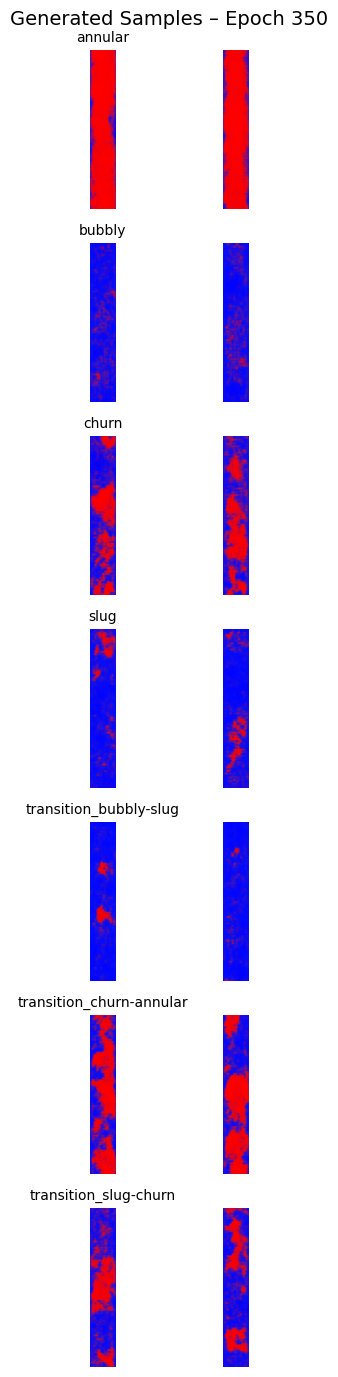

Checkpoint saved at epoch 350
Epoch 350 | Gen Loss: 0.6932 | Disc Loss: 1.3858


Epoch 351: 0it [00:00, ?it/s]

Epoch 351 | Gen Loss: 0.6923 | Disc Loss: 1.3864


Epoch 352: 0it [00:00, ?it/s]

Epoch 352 | Gen Loss: 0.6942 | Disc Loss: 1.3876


Epoch 353: 0it [00:00, ?it/s]

Epoch 353 | Gen Loss: 0.6935 | Disc Loss: 1.3872


Epoch 354: 0it [00:00, ?it/s]

Epoch 354 | Gen Loss: 0.6954 | Disc Loss: 1.3876


Epoch 355: 0it [00:00, ?it/s]

Epoch 355 | Gen Loss: 0.6957 | Disc Loss: 1.3866


Epoch 356: 0it [00:00, ?it/s]

Epoch 356 | Gen Loss: 0.6926 | Disc Loss: 1.3871


Epoch 357: 0it [00:00, ?it/s]

Epoch 357 | Gen Loss: 0.6938 | Disc Loss: 1.3867


Epoch 358: 0it [00:00, ?it/s]

Epoch 358 | Gen Loss: 0.6944 | Disc Loss: 1.3877


Epoch 359: 0it [00:00, ?it/s]

Epoch 359 | Gen Loss: 0.6927 | Disc Loss: 1.3878


Epoch 360: 0it [00:00, ?it/s]

Checkpoint saved at epoch 360
Epoch 360 | Gen Loss: 0.6950 | Disc Loss: 1.3866


Epoch 361: 0it [00:00, ?it/s]

Epoch 361 | Gen Loss: 0.6947 | Disc Loss: 1.3872


Epoch 362: 0it [00:00, ?it/s]

Epoch 362 | Gen Loss: 0.6927 | Disc Loss: 1.3870


Epoch 363: 0it [00:00, ?it/s]

Epoch 363 | Gen Loss: 0.6907 | Disc Loss: 1.3875


Epoch 364: 0it [00:00, ?it/s]

Epoch 364 | Gen Loss: 0.6917 | Disc Loss: 1.3875


Epoch 365: 0it [00:00, ?it/s]

Epoch 365 | Gen Loss: 0.6944 | Disc Loss: 1.3869


Epoch 366: 0it [00:00, ?it/s]

Epoch 366 | Gen Loss: 0.6930 | Disc Loss: 1.3853


Epoch 367: 0it [00:00, ?it/s]

Epoch 367 | Gen Loss: 0.6983 | Disc Loss: 1.3878


Epoch 368: 0it [00:00, ?it/s]

Epoch 368 | Gen Loss: 0.6950 | Disc Loss: 1.3870


Epoch 369: 0it [00:00, ?it/s]

Epoch 369 | Gen Loss: 0.6940 | Disc Loss: 1.3874


Epoch 370: 0it [00:00, ?it/s]

Checkpoint saved at epoch 370
Epoch 370 | Gen Loss: 0.6955 | Disc Loss: 1.3864


Epoch 371: 0it [00:00, ?it/s]

Epoch 371 | Gen Loss: 0.6930 | Disc Loss: 1.3867


Epoch 372: 0it [00:00, ?it/s]

Epoch 372 | Gen Loss: 0.6943 | Disc Loss: 1.3872


Epoch 373: 0it [00:00, ?it/s]

Epoch 373 | Gen Loss: 0.6949 | Disc Loss: 1.3866


Epoch 374: 0it [00:00, ?it/s]

Epoch 374 | Gen Loss: 0.6941 | Disc Loss: 1.3867


Epoch 375: 0it [00:00, ?it/s]

Epoch 375 | Gen Loss: 0.6945 | Disc Loss: 1.3871


Epoch 376: 0it [00:00, ?it/s]

Epoch 376 | Gen Loss: 0.6928 | Disc Loss: 1.3869


Epoch 377: 0it [00:00, ?it/s]

Epoch 377 | Gen Loss: 0.6942 | Disc Loss: 1.3873


Epoch 378: 0it [00:00, ?it/s]

Epoch 378 | Gen Loss: 0.6917 | Disc Loss: 1.3873


Epoch 379: 0it [00:00, ?it/s]

Epoch 379 | Gen Loss: 0.6952 | Disc Loss: 1.3870


Epoch 380: 0it [00:00, ?it/s]

Checkpoint saved at epoch 380
Epoch 380 | Gen Loss: 0.6930 | Disc Loss: 1.3872


Epoch 381: 0it [00:00, ?it/s]

Epoch 381 | Gen Loss: 0.6942 | Disc Loss: 1.3874


Epoch 382: 0it [00:00, ?it/s]

Epoch 382 | Gen Loss: 0.6928 | Disc Loss: 1.3870


Epoch 383: 0it [00:00, ?it/s]

Epoch 383 | Gen Loss: 0.6923 | Disc Loss: 1.3871


Epoch 384: 0it [00:00, ?it/s]

Epoch 384 | Gen Loss: 0.6942 | Disc Loss: 1.3873


Epoch 385: 0it [00:00, ?it/s]

Epoch 385 | Gen Loss: 0.6938 | Disc Loss: 1.3867


Epoch 386: 0it [00:00, ?it/s]

Epoch 386 | Gen Loss: 0.6933 | Disc Loss: 1.3871


Epoch 387: 0it [00:00, ?it/s]

Epoch 387 | Gen Loss: 0.6925 | Disc Loss: 1.3867


Epoch 388: 0it [00:00, ?it/s]

Epoch 388 | Gen Loss: 0.6950 | Disc Loss: 1.3872


Epoch 389: 0it [00:00, ?it/s]

Epoch 389 | Gen Loss: 0.6944 | Disc Loss: 1.3868


Epoch 390: 0it [00:00, ?it/s]

Checkpoint saved at epoch 390
Epoch 390 | Gen Loss: 0.6924 | Disc Loss: 1.3873


Epoch 391: 0it [00:00, ?it/s]

Epoch 391 | Gen Loss: 0.6929 | Disc Loss: 1.3869


Epoch 392: 0it [00:00, ?it/s]

Epoch 392 | Gen Loss: 0.6954 | Disc Loss: 1.3872


Epoch 393: 0it [00:00, ?it/s]

Epoch 393 | Gen Loss: 0.6913 | Disc Loss: 1.3869


Epoch 394: 0it [00:00, ?it/s]

Epoch 394 | Gen Loss: 0.6975 | Disc Loss: 1.3859


Epoch 395: 0it [00:00, ?it/s]

Epoch 395 | Gen Loss: 0.6903 | Disc Loss: 1.3875


Epoch 396: 0it [00:00, ?it/s]

Epoch 396 | Gen Loss: 0.6929 | Disc Loss: 1.3870


Epoch 397: 0it [00:00, ?it/s]

Epoch 397 | Gen Loss: 0.6930 | Disc Loss: 1.3869


Epoch 398: 0it [00:00, ?it/s]

Epoch 398 | Gen Loss: 0.6945 | Disc Loss: 1.3873


Epoch 399: 0it [00:00, ?it/s]

Epoch 399 | Gen Loss: 0.6928 | Disc Loss: 1.3868


Epoch 400: 0it [00:00, ?it/s]

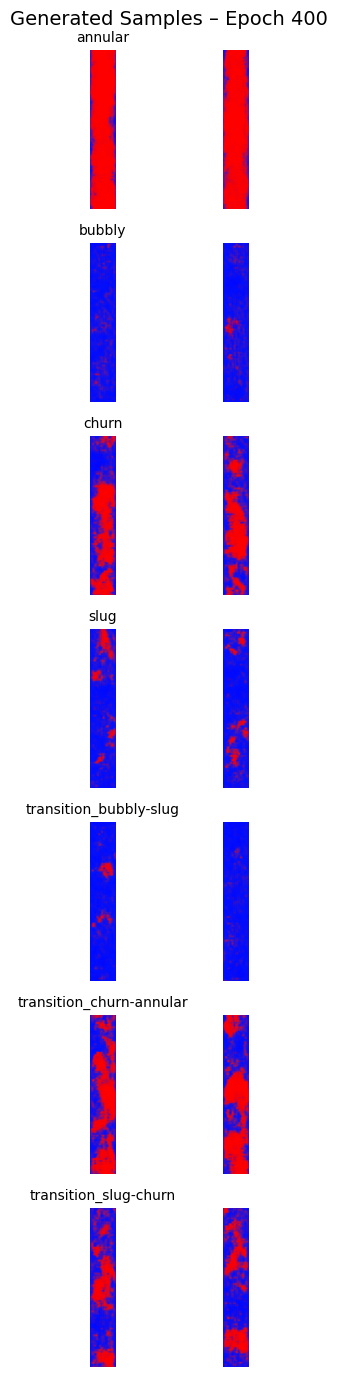

Checkpoint saved at epoch 400
Epoch 400 | Gen Loss: 0.6933 | Disc Loss: 1.3869


Epoch 401: 0it [00:00, ?it/s]

Epoch 401 | Gen Loss: 0.6936 | Disc Loss: 1.3865


Epoch 402: 0it [00:00, ?it/s]

Epoch 402 | Gen Loss: 0.6946 | Disc Loss: 1.3867


Epoch 403: 0it [00:00, ?it/s]

Epoch 403 | Gen Loss: 0.6943 | Disc Loss: 1.3866


Epoch 404: 0it [00:00, ?it/s]

Epoch 404 | Gen Loss: 0.6914 | Disc Loss: 1.3874


Epoch 405: 0it [00:00, ?it/s]

Epoch 405 | Gen Loss: 0.6936 | Disc Loss: 1.3868


Epoch 406: 0it [00:00, ?it/s]

Epoch 406 | Gen Loss: 0.6930 | Disc Loss: 1.3873


Epoch 407: 0it [00:00, ?it/s]

Epoch 407 | Gen Loss: 0.6939 | Disc Loss: 1.3867


Epoch 408: 0it [00:00, ?it/s]

Epoch 408 | Gen Loss: 0.6945 | Disc Loss: 1.3871


Epoch 409: 0it [00:00, ?it/s]

Epoch 409 | Gen Loss: 0.6937 | Disc Loss: 1.3861


Epoch 410: 0it [00:00, ?it/s]

Checkpoint saved at epoch 410
Epoch 410 | Gen Loss: 0.6926 | Disc Loss: 1.3867


Epoch 411: 0it [00:00, ?it/s]

Epoch 411 | Gen Loss: 0.6936 | Disc Loss: 1.3873


Epoch 412: 0it [00:00, ?it/s]

Epoch 412 | Gen Loss: 0.6921 | Disc Loss: 1.3871


Epoch 413: 0it [00:00, ?it/s]

Epoch 413 | Gen Loss: 0.6956 | Disc Loss: 1.3869


Epoch 414: 0it [00:00, ?it/s]

Epoch 414 | Gen Loss: 0.6915 | Disc Loss: 1.3871


Epoch 415: 0it [00:00, ?it/s]

Epoch 415 | Gen Loss: 0.6942 | Disc Loss: 1.3871


Epoch 416: 0it [00:00, ?it/s]

Epoch 416 | Gen Loss: 0.6932 | Disc Loss: 1.3865


Epoch 417: 0it [00:00, ?it/s]

Epoch 417 | Gen Loss: 0.6946 | Disc Loss: 1.3869


Epoch 418: 0it [00:00, ?it/s]

Epoch 418 | Gen Loss: 0.6954 | Disc Loss: 1.3872


Epoch 419: 0it [00:00, ?it/s]

Epoch 419 | Gen Loss: 0.6921 | Disc Loss: 1.3869


Epoch 420: 0it [00:00, ?it/s]

Checkpoint saved at epoch 420
Epoch 420 | Gen Loss: 0.6942 | Disc Loss: 1.3867


Epoch 421: 0it [00:00, ?it/s]

Epoch 421 | Gen Loss: 0.6931 | Disc Loss: 1.3865


Epoch 422: 0it [00:00, ?it/s]

Epoch 422 | Gen Loss: 0.6919 | Disc Loss: 1.3869


Epoch 423: 0it [00:00, ?it/s]

Epoch 423 | Gen Loss: 0.6951 | Disc Loss: 1.3865


Epoch 424: 0it [00:00, ?it/s]

Epoch 424 | Gen Loss: 0.6951 | Disc Loss: 1.3861


Epoch 425: 0it [00:00, ?it/s]

Epoch 425 | Gen Loss: 0.6932 | Disc Loss: 1.3868


Epoch 426: 0it [00:00, ?it/s]

Epoch 426 | Gen Loss: 0.6935 | Disc Loss: 1.3871


Epoch 427: 0it [00:00, ?it/s]

Epoch 427 | Gen Loss: 0.6930 | Disc Loss: 1.3871


Epoch 428: 0it [00:00, ?it/s]

Epoch 428 | Gen Loss: 0.6937 | Disc Loss: 1.3871


Epoch 429: 0it [00:00, ?it/s]

Epoch 429 | Gen Loss: 0.6924 | Disc Loss: 1.3872


Epoch 430: 0it [00:00, ?it/s]

Checkpoint saved at epoch 430
Epoch 430 | Gen Loss: 0.6947 | Disc Loss: 1.3871


Epoch 431: 0it [00:00, ?it/s]

Epoch 431 | Gen Loss: 0.6930 | Disc Loss: 1.3860


Epoch 432: 0it [00:00, ?it/s]

Epoch 432 | Gen Loss: 0.6932 | Disc Loss: 1.3867


Epoch 433: 0it [00:00, ?it/s]

Epoch 433 | Gen Loss: 0.6931 | Disc Loss: 1.3871


Epoch 434: 0it [00:00, ?it/s]

Epoch 434 | Gen Loss: 0.6941 | Disc Loss: 1.3869


Epoch 435: 0it [00:00, ?it/s]

Epoch 435 | Gen Loss: 0.6929 | Disc Loss: 1.3872


Epoch 436: 0it [00:00, ?it/s]

Epoch 436 | Gen Loss: 0.6958 | Disc Loss: 1.3873


Epoch 437: 0it [00:00, ?it/s]

Epoch 437 | Gen Loss: 0.6900 | Disc Loss: 1.3871


Epoch 438: 0it [00:00, ?it/s]

Epoch 438 | Gen Loss: 0.6932 | Disc Loss: 1.3875


Epoch 439: 0it [00:00, ?it/s]

Epoch 439 | Gen Loss: 0.6945 | Disc Loss: 1.3871


Epoch 440: 0it [00:00, ?it/s]

Checkpoint saved at epoch 440
Epoch 440 | Gen Loss: 0.6920 | Disc Loss: 1.3869


Epoch 441: 0it [00:00, ?it/s]

Epoch 441 | Gen Loss: 0.6937 | Disc Loss: 1.3872


Epoch 442: 0it [00:00, ?it/s]

Epoch 442 | Gen Loss: 0.6937 | Disc Loss: 1.3872


Epoch 443: 0it [00:00, ?it/s]

Epoch 443 | Gen Loss: 0.6947 | Disc Loss: 1.3858


Epoch 444: 0it [00:00, ?it/s]

Epoch 444 | Gen Loss: 0.6937 | Disc Loss: 1.3872


Epoch 445: 0it [00:00, ?it/s]

Epoch 445 | Gen Loss: 0.6926 | Disc Loss: 1.3870


Epoch 446: 0it [00:00, ?it/s]

Epoch 446 | Gen Loss: 0.6927 | Disc Loss: 1.3866


Epoch 447: 0it [00:00, ?it/s]

Epoch 447 | Gen Loss: 0.6953 | Disc Loss: 1.3872


Epoch 448: 0it [00:00, ?it/s]

Epoch 448 | Gen Loss: 0.6932 | Disc Loss: 1.3871


Epoch 449: 0it [00:00, ?it/s]

Epoch 449 | Gen Loss: 0.6917 | Disc Loss: 1.3864


Epoch 450: 0it [00:00, ?it/s]

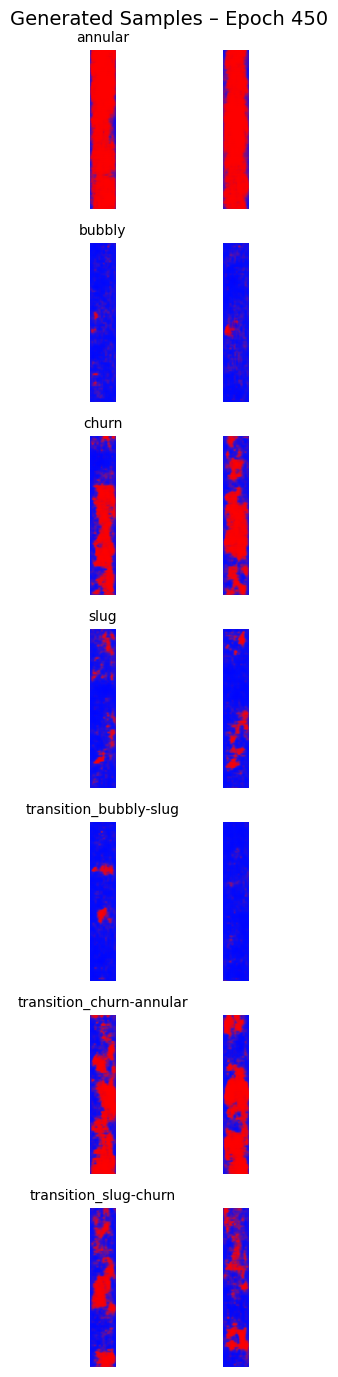

Checkpoint saved at epoch 450
Epoch 450 | Gen Loss: 0.6941 | Disc Loss: 1.3868


Epoch 451: 0it [00:00, ?it/s]

Epoch 451 | Gen Loss: 0.6934 | Disc Loss: 1.3868


Epoch 452: 0it [00:00, ?it/s]

Epoch 452 | Gen Loss: 0.6923 | Disc Loss: 1.3864


Epoch 453: 0it [00:00, ?it/s]

Epoch 453 | Gen Loss: 0.6940 | Disc Loss: 1.3871


Epoch 454: 0it [00:00, ?it/s]

Epoch 454 | Gen Loss: 0.6947 | Disc Loss: 1.3870


Epoch 455: 0it [00:00, ?it/s]

Epoch 455 | Gen Loss: 0.6940 | Disc Loss: 1.3868


Epoch 456: 0it [00:00, ?it/s]

Epoch 456 | Gen Loss: 0.6954 | Disc Loss: 1.3869


Epoch 457: 0it [00:00, ?it/s]

Epoch 457 | Gen Loss: 0.6923 | Disc Loss: 1.3869


Epoch 458: 0it [00:00, ?it/s]

Epoch 458 | Gen Loss: 0.6916 | Disc Loss: 1.3865


Epoch 459: 0it [00:00, ?it/s]

Epoch 459 | Gen Loss: 0.6953 | Disc Loss: 1.3870


Epoch 460: 0it [00:00, ?it/s]

Checkpoint saved at epoch 460
Epoch 460 | Gen Loss: 0.6928 | Disc Loss: 1.3870


Epoch 461: 0it [00:00, ?it/s]

Epoch 461 | Gen Loss: 0.6962 | Disc Loss: 1.3866


Epoch 462: 0it [00:00, ?it/s]

Epoch 462 | Gen Loss: 0.6910 | Disc Loss: 1.3877


Epoch 463: 0it [00:00, ?it/s]

Epoch 463 | Gen Loss: 0.6937 | Disc Loss: 1.3866


Epoch 464: 0it [00:00, ?it/s]

Epoch 464 | Gen Loss: 0.6917 | Disc Loss: 1.3869


Epoch 465: 0it [00:00, ?it/s]

Epoch 465 | Gen Loss: 0.6931 | Disc Loss: 1.3871


Epoch 466: 0it [00:00, ?it/s]

Epoch 466 | Gen Loss: 0.6927 | Disc Loss: 1.3869


Epoch 467: 0it [00:00, ?it/s]

Epoch 467 | Gen Loss: 0.6922 | Disc Loss: 1.3867


Epoch 468: 0it [00:00, ?it/s]

Epoch 468 | Gen Loss: 0.6974 | Disc Loss: 1.3866


Epoch 469: 0it [00:00, ?it/s]

Epoch 469 | Gen Loss: 0.6922 | Disc Loss: 1.3872


Epoch 470: 0it [00:00, ?it/s]

Checkpoint saved at epoch 470
Epoch 470 | Gen Loss: 0.6946 | Disc Loss: 1.3868


Epoch 471: 0it [00:00, ?it/s]

Epoch 471 | Gen Loss: 0.6924 | Disc Loss: 1.3868


Epoch 472: 0it [00:00, ?it/s]

Epoch 472 | Gen Loss: 0.6955 | Disc Loss: 1.3863


Epoch 473: 0it [00:00, ?it/s]

Epoch 473 | Gen Loss: 0.6914 | Disc Loss: 1.3868


Epoch 474: 0it [00:00, ?it/s]

Epoch 474 | Gen Loss: 0.6928 | Disc Loss: 1.3869


Epoch 475: 0it [00:00, ?it/s]

Epoch 475 | Gen Loss: 0.6937 | Disc Loss: 1.3869


Epoch 476: 0it [00:00, ?it/s]

Epoch 476 | Gen Loss: 0.6941 | Disc Loss: 1.3865


Epoch 477: 0it [00:00, ?it/s]

Epoch 477 | Gen Loss: 0.6946 | Disc Loss: 1.3868


Epoch 478: 0it [00:00, ?it/s]

Epoch 478 | Gen Loss: 0.6923 | Disc Loss: 1.3871


Epoch 479: 0it [00:00, ?it/s]

Epoch 479 | Gen Loss: 0.6933 | Disc Loss: 1.3866


Epoch 480: 0it [00:00, ?it/s]

Checkpoint saved at epoch 480
Epoch 480 | Gen Loss: 0.6947 | Disc Loss: 1.3865


Epoch 481: 0it [00:00, ?it/s]

Epoch 481 | Gen Loss: 0.6931 | Disc Loss: 1.3873


Epoch 482: 0it [00:00, ?it/s]

Epoch 482 | Gen Loss: 0.6918 | Disc Loss: 1.3868


Epoch 483: 0it [00:00, ?it/s]

Epoch 483 | Gen Loss: 0.6936 | Disc Loss: 1.3867


Epoch 484: 0it [00:00, ?it/s]

Epoch 484 | Gen Loss: 0.6945 | Disc Loss: 1.3867


Epoch 485: 0it [00:00, ?it/s]

Epoch 485 | Gen Loss: 0.6913 | Disc Loss: 1.3867


Epoch 486: 0it [00:00, ?it/s]

Epoch 486 | Gen Loss: 0.6942 | Disc Loss: 1.3867


Epoch 487: 0it [00:00, ?it/s]

Epoch 487 | Gen Loss: 0.6940 | Disc Loss: 1.3869


Epoch 488: 0it [00:00, ?it/s]

Epoch 488 | Gen Loss: 0.6934 | Disc Loss: 1.3869


Epoch 489: 0it [00:00, ?it/s]

Epoch 489 | Gen Loss: 0.6945 | Disc Loss: 1.3868


Epoch 490: 0it [00:00, ?it/s]

Checkpoint saved at epoch 490
Epoch 490 | Gen Loss: 0.6909 | Disc Loss: 1.3865


Epoch 491: 0it [00:00, ?it/s]

Epoch 491 | Gen Loss: 0.6955 | Disc Loss: 1.3866


Epoch 492: 0it [00:00, ?it/s]

Epoch 492 | Gen Loss: 0.6917 | Disc Loss: 1.3867


Epoch 493: 0it [00:00, ?it/s]

Epoch 493 | Gen Loss: 0.6934 | Disc Loss: 1.3863


Epoch 494: 0it [00:00, ?it/s]

Epoch 494 | Gen Loss: 0.6935 | Disc Loss: 1.3871


Epoch 495: 0it [00:00, ?it/s]

Epoch 495 | Gen Loss: 0.6939 | Disc Loss: 1.3867


Epoch 496: 0it [00:00, ?it/s]

Epoch 496 | Gen Loss: 0.6972 | Disc Loss: 1.3870


Epoch 497: 0it [00:00, ?it/s]

Epoch 497 | Gen Loss: 0.6938 | Disc Loss: 1.3866


Epoch 498: 0it [00:00, ?it/s]

Epoch 498 | Gen Loss: 0.6908 | Disc Loss: 1.3869


Epoch 499: 0it [00:00, ?it/s]

Epoch 499 | Gen Loss: 0.6916 | Disc Loss: 1.3868


Epoch 500: 0it [00:00, ?it/s]

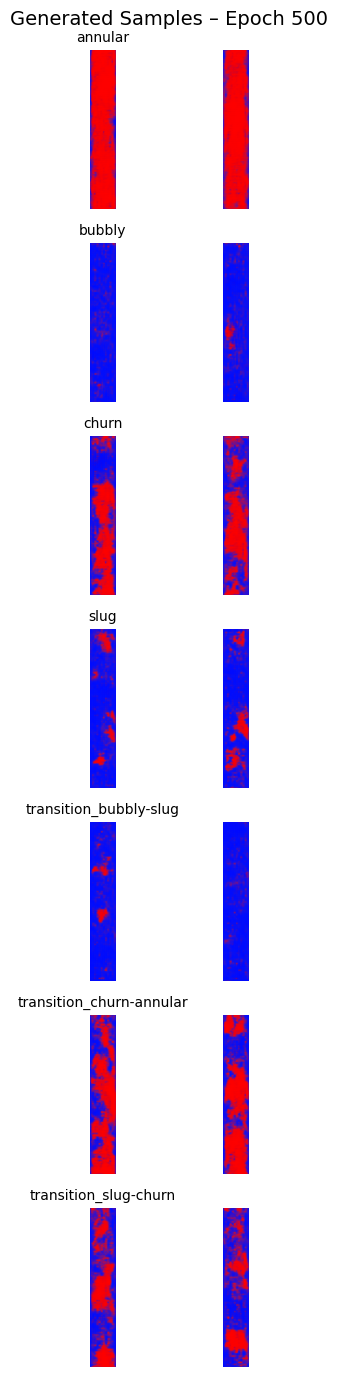

Checkpoint saved at epoch 500
Epoch 500 | Gen Loss: 0.6929 | Disc Loss: 1.3868


In [10]:
# Cell 9
from tqdm.notebook import tqdm
import time

# Sample grid setup
examples_per_class = 2
total = NUM_CLASSES * examples_per_class
seed_noise = tf.random.normal([total, LATENT_DIM])
seed_labels = tf.one_hot(tf.repeat(tf.range(NUM_CLASSES), examples_per_class), NUM_CLASSES)
class_names = ['annular', 'bubbly', 'churn', 'slug',
               'transition_bubbly-slug', 'transition_churn-annular', 'transition_slug-churn']

# Loss history trackers
gen_losses = []
disc_losses = []

def plot_samples(epoch):
    fake = generator([seed_noise, seed_labels], training=False)
    fig, axes = plt.subplots(NUM_CLASSES, examples_per_class, figsize=(examples_per_class * 2, NUM_CLASSES * 2))

    for i in range(total):
        r, c = divmod(i, examples_per_class)
        img = (fake[i] + 1) * 0.5
        axes[r, c].imshow(img)
        axes[r, c].axis('off')
        if c == 0:
            axes[r, c].set_title(class_names[r], fontsize=10)

    plt.suptitle(f"Generated Samples – Epoch {epoch}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Main training loop
for epoch in range(1, 501):  # 500 epochs
    g_avg = tf.keras.metrics.Mean()
    d_avg = tf.keras.metrics.Mean()
    pbar = tqdm(dataset, desc=f"Epoch {epoch:03d}", leave=False)

    for real_img, lbl in pbar:
        gl, dl = train_step(real_img, lbl)
        g_avg.update_state(gl)
        d_avg.update_state(dl)
        pbar.set_postfix({"GenLoss": f"{gl:.4f}", "DiscLoss": f"{dl:.4f}"})

    # Store epoch losses
    gen_losses.append(float(g_avg.result()))
    disc_losses.append(float(d_avg.result()))

    # Plot samples every 50 epochs
    if epoch % 50 == 0:
        plot_samples(epoch)

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        gen_path = os.path.join(CHECKPOINT_DIR, f'generator_epoch_{epoch:03d}.h5')
        disc_path = os.path.join(CHECKPOINT_DIR, f'discriminator_epoch_{epoch:03d}.h5')
        generator.save(gen_path)
        discriminator.save(disc_path)
        print(f"Checkpoint saved at epoch {epoch}")

    # Log losses per epoch
    print(f"Epoch {epoch:03d} | Gen Loss: {gen_losses[-1]:.4f} | Disc Loss: {disc_losses[-1]:.4f}")

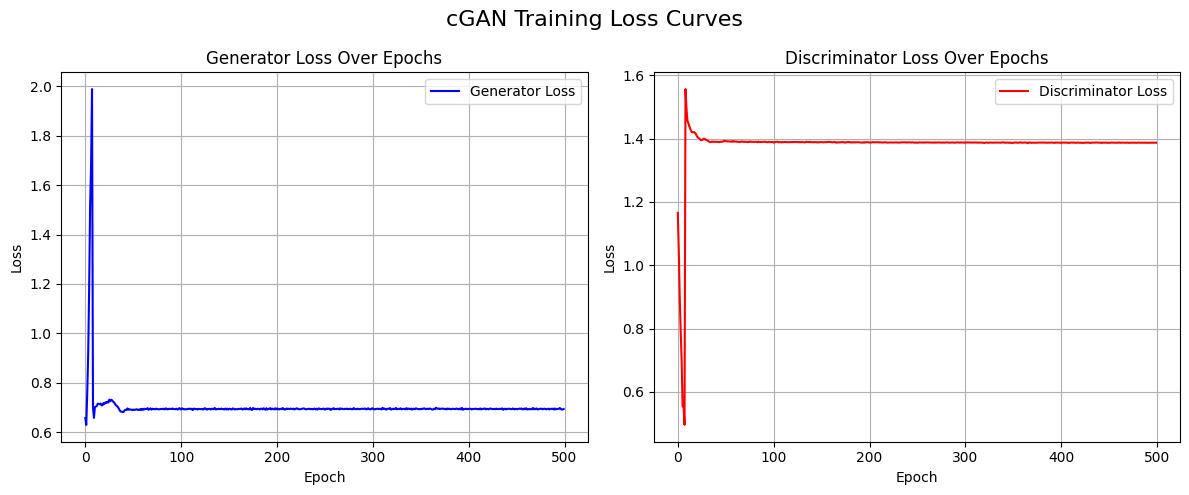

In [11]:
# Cell 10
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Generator Loss
plt.subplot(1, 2, 1)
plt.plot(gen_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss Over Epochs')
plt.grid(True)
plt.legend()

# Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(disc_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Epochs')
plt.grid(True)
plt.legend()

plt.suptitle('cGAN Training Loss Curves', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
# Cell 11
import cv2

# Save to Drive for persistence
synthetic_dir = '/content/drive/MyDrive/GenGAN/synthetic'
os.makedirs(synthetic_dir, exist_ok=True)

# Class name mapping
class_names = ['annular', 'bubbly', 'churn', 'slug',
               'transition_bubbly-slug', 'transition_churn-annular', 'transition_slug-churn']

def generate_synthetic_class(class_id, count=200):
    cname = class_names[class_id]
    img_dir = os.path.join(synthetic_dir, cname, 'images')
    lbl_dir = os.path.join(synthetic_dir, cname, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    batches = count // BATCH_SIZE + int(count % BATCH_SIZE > 0)
    generated = 0

    for _ in range(batches):
        batch_size = min(BATCH_SIZE, count - generated)
        noise = tf.random.normal([batch_size, LATENT_DIM])
        labels = tf.one_hot([class_id] * batch_size, NUM_CLASSES)
        fake_imgs = generator([noise, labels], training=False)
        fake_imgs = ((fake_imgs + 1) * 127.5).numpy().astype(np.uint8)

        for i in range(batch_size):
            idx = generated + i
            img = fake_imgs[i]
            img_path = os.path.join(img_dir, f'{cname}_{idx:04d}.png')
            lbl_path = os.path.join(lbl_dir, f'{cname}_{idx:04d}.txt')

            # Save image
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            # Write YOLO label (full-frame)
            with open(lbl_path, 'w') as f:
                f.write(f"{class_id} 0.5 0.5 1 1\n")

        generated += batch_size
        print(f"{generated}/{count} saved for class: {cname}")

# Generate for all classes
for cid in range(NUM_CLASSES):
    generate_synthetic_class(cid, count=200)

print("All synthetic samples and full-frame labels saved to Drive.")

28/200 saved for class: annular
56/200 saved for class: annular
84/200 saved for class: annular
112/200 saved for class: annular
140/200 saved for class: annular
168/200 saved for class: annular
196/200 saved for class: annular
200/200 saved for class: annular
28/200 saved for class: bubbly
56/200 saved for class: bubbly
84/200 saved for class: bubbly
112/200 saved for class: bubbly
140/200 saved for class: bubbly
168/200 saved for class: bubbly
196/200 saved for class: bubbly
200/200 saved for class: bubbly
28/200 saved for class: churn
56/200 saved for class: churn
84/200 saved for class: churn
112/200 saved for class: churn
140/200 saved for class: churn
168/200 saved for class: churn
196/200 saved for class: churn
200/200 saved for class: churn
28/200 saved for class: slug
56/200 saved for class: slug
84/200 saved for class: slug
112/200 saved for class: slug
140/200 saved for class: slug
168/200 saved for class: slug
196/200 saved for class: slug
200/200 saved for class: slug
28/2

In [18]:
# Cell 13 – Intra-Class Pixel Variance
import numpy as np

def compute_variance_for_class(class_name):
    img_dir = f"/content/drive/MyDrive/GenGAN/synthetic/{class_name}/images"
    img_paths = sorted(glob.glob(f"{img_dir}/*.png"))

    imgs = []
    for p in img_paths:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img.astype(np.float32))

    imgs = np.stack(imgs)
    variance = np.var(imgs, axis=0)
    return np.mean(variance)

for cname in class_names:
    v = compute_variance_for_class(cname)
    print(f"Variance for {cname}: {v:.2f}")

Variance for annular: 669.85
Variance for bubbly: 428.59
Variance for churn: 3844.60
Variance for slug: 2592.47
Variance for transition_bubbly-slug: 1185.72
Variance for transition_churn-annular: 4248.86
Variance for transition_slug-churn: 3937.77


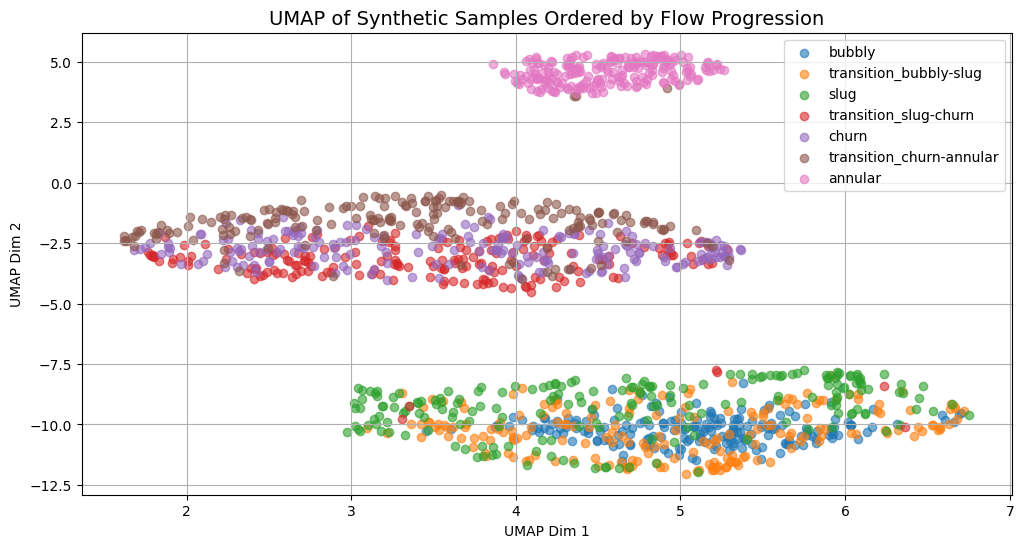

In [19]:
# Cell 14 – UMAP Embedding of Synthetic Samples (Ordered by Flow Progression)
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

flow_order = ['bubbly',
              'transition_bubbly-slug',
              'slug',
              'transition_slug-churn',
              'churn',
              'transition_churn-annular',
              'annular']

def embed_class_images(class_name):
    img_dir = f"/content/drive/MyDrive/GenGAN/synthetic/{class_name}/images"
    paths = sorted(glob.glob(f"{img_dir}/*.png"))
    feats = []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, (96, 96))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        feats.append(img.flatten())
    return np.array(feats)

all_feats = []
all_labels = []
for cname in flow_order:
    feats = embed_class_images(cname)
    all_feats.append(feats)
    all_labels.extend([cname] * feats.shape[0])
all_feats = np.vstack(all_feats)

# Apply PCA + UMAP
pca = PCA(n_components=50).fit_transform(all_feats)
umap_embed = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(pca)

# Plot UMAP with flow ordering
plt.figure(figsize=(12, 6))
for cname in flow_order:
    idx = [i for i, label in enumerate(all_labels) if label == cname]
    plt.scatter(umap_embed[idx, 0], umap_embed[idx, 1], label=cname, alpha=0.6)

plt.legend()
plt.title("UMAP of Synthetic Samples Ordered by Flow Progression", fontsize=14)
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.grid(True)
plt.show()

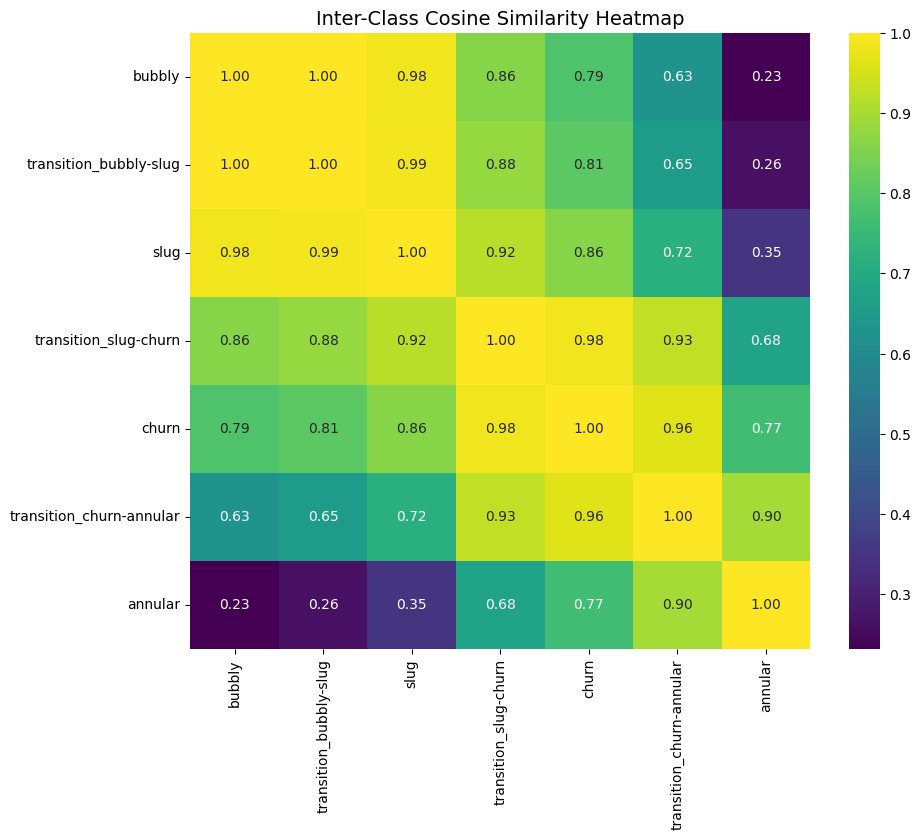

In [20]:
# Cell 15 – Inter-Class Similarity Heatmap
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def get_class_centroid(class_name):
    img_dir = f"/content/drive/MyDrive/GenGAN/synthetic/{class_name}/images"
    paths = sorted(glob.glob(f"{img_dir}/*.png"))
    vectors = []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, (96, 96))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        vectors.append(img.flatten())
    return np.mean(vectors, axis=0)

centroids = [get_class_centroid(cname) for cname in flow_order]
similarities = cosine_similarity(centroids)

plt.figure(figsize=(10, 8))
sns.heatmap(similarities, xticklabels=flow_order, yticklabels=flow_order, cmap='viridis', annot=True, fmt=".2f")
plt.title("Inter-Class Cosine Similarity Heatmap", fontsize=14)
plt.show()

In [21]:
# Cell 16 – Latent Entropy per Class
from scipy.stats import entropy

def compute_entropy(class_id, samples=500):
    noise = tf.random.normal([samples, LATENT_DIM])
    labels = tf.one_hot([class_id] * samples, NUM_CLASSES)
    latent = generator([noise, labels], training=False).numpy().reshape(samples, -1)
    latent = (latent + 1) * 127.5
    latent = latent.astype(np.uint8)

    histograms = [np.histogram(img, bins=50, range=(0, 255))[0] for img in latent]
    entropies = [entropy(h + 1) for h in histograms]
    return np.mean(entropies)

for cid, cname in enumerate(flow_order):
    e = compute_entropy(cid)
    print(f"Latent Entropy for {cname}: {e:.2f}")

Latent Entropy for bubbly: 2.60
Latent Entropy for transition_bubbly-slug: 2.77
Latent Entropy for slug: 3.41
Latent Entropy for transition_slug-churn: 2.87
Latent Entropy for churn: 2.75
Latent Entropy for transition_churn-annular: 3.26
Latent Entropy for annular: 3.36


In [22]:
# Cell 17 – Mode Count with KMeans
from sklearn.cluster import KMeans

def compute_mode_count(class_name, k=10):
    img_dir = f"/content/drive/MyDrive/GenGAN/synthetic/{class_name}/images"
    paths = sorted(glob.glob(f"{img_dir}/*.png"))
    vectors = []

    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, (96, 96))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        vectors.append(img.flatten())

    X = np.stack(vectors)
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    return len(np.unique(km.labels_))

for cname in flow_order:
    modes = compute_mode_count(cname, k=10)
    print(f"Mode Count for {cname}: {modes}")

Mode Count for bubbly: 10
Mode Count for transition_bubbly-slug: 10
Mode Count for slug: 10
Mode Count for transition_slug-churn: 10
Mode Count for churn: 10
Mode Count for transition_churn-annular: 10
Mode Count for annular: 10
